# Genre Explorations and Predictions

This project started out as an investigation into training a machine learing model to predict genres utilizing data scraped from the spotify api. Further investigation led to a cross examination of how human intuition, particulary my own intuition, compares to machine learning clustering algorithms. 

The first part of this project is about learning to use spotipy, a python wrapper for the spotify api. Scrapped data was saved as .csv files. Some data munging came next dealing with nulls and duplicated data. 
The second part was the most crucial to this project. The song data from spotify came with multiple genres attached to an artist/song. To make a predictor, each song would need a concise genre to target. This led me to a binning function where each song was chosen carefully into 12 genres. This function added subjectivity to the modeling process as different people will interperet what genres should be binned into. Once all the songs were binned, more munging followed as songs which did not fit into any genre were given NaN values and removed. 

An extensive amount of Exploratory Data Analysis followed. Every feature of each genre was charted in order to see, similarities, differences and to search for outlier values. Seeing each genre's features graphed out would be the first test of the binning function and its effectiveness.

The modeling process than followed. The data was split into a training, validation and testing sets.  Many classification models were employed including, Logistic Regression, Random Forest, Stochastic Gradient Descent, Extreme Gradient Boosting and a Neural Network. These model were fitted on the training set, tunned on validation and ultimatly scored on the testing set. 

Next was exploring how well a machine learning alogrithm, know as k-means cluster, can produce 12 distinct genres. 12 distict clusters were made and treated as genres. Each cluster was given extensive exploratory data analysis, with charts of each cluster's feature. The last part of the project was seeing how the 12 binned genres compared to the 12 clusters.


In [1]:
import spotipy as sp
import spotipy.util as util
import pandas as pd
import json
import time
import requests as re
from spotipy import oauth2
import regex
import numpy as np
import matplotlib.pyplot as plt



In [263]:
# Obtaining an authentication token for the spotify API ututilizing spotipy, a python wrapper
token = util.prompt_for_user_token(username='u76krgcu2i52isp9ktf2acmmp', 
                           scope='user-library-read',
                           client_id='71f8b6e1b36740a8acda7e15c5e1d73d',
                           client_secret='ebb9411ac7f5455a9cbb752dbb7e4f9f',
                           redirect_uri='https://example.com/callbacks')

In [261]:
# Creating a spotipy object called spot
spot= sp.Spotify(auth=token)


In [4]:
# Checking to see if I am connected to spotify API by getting genre seeds
genres = pd.DataFrame(spot.recommendation_genre_seeds())
genres.genres.unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'bossanova',
       'brazil', 'breakbeat', 'british', 'cantopop', 'chicago-house',
       'children', 'chill', 'classical', 'club', 'comedy', 'country',
       'dance', 'dancehall', 'death-metal', 'deep-house',
       'detroit-techno', 'disco', 'disney', 'drum-and-bass', 'dub',
       'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro',
       'french', 'funk', 'garage', 'german', 'gospel', 'goth',
       'grindcore', 'groove', 'grunge', 'guitar', 'happy', 'hard-rock',
       'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'holidays',
       'honky-tonk', 'house', 'idm', 'indian', 'indie', 'indie-pop',
       'industrial', 'iranian', 'j-dance', 'j-idol', 'j-pop', 'j-rock',
       'jazz', 'k-pop', 'kids', 'latin', 'latino', 'malay', 'mandopop',
       'metal', 'metal-misc', 'metalcore', 'minimal-techno', 'movies',
       'mpb', 'new-age', 'new-releas

In [162]:
#List of artist's name on spotify obtained from kaggle
artist_list = pd.read_csv('./artist-uris.csv.csv', header=None) 

In [15]:
# cleaning dataframe, drop nulls and nonessetial columns
artist_list.dropna(axis=0, inplace=True)

In [16]:
artist_list.isnull().sum()

0    0
1    0
dtype: int64

In [163]:
#renaming columns
artist_list.rename(columns={0:'artist', 1:'id'}, inplace=True)

In [20]:
#Example of a spotipy search object, output is a dictionary
results_t = spot.search(q='Michael-Jackson',limit=1, type='track')



{'artists': {'href': 'https://api.spotify.com/v1/search?query=Basslovers+United&type=artist&market=US&offset=0&limit=1',
  'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4KpgeSLtjj0txr6drzaedu'},
    'followers': {'href': None, 'total': 14103},
    'genres': ['eurodance', 'hands up', 'pop house'],
    'href': 'https://api.spotify.com/v1/artists/4KpgeSLtjj0txr6drzaedu',
    'id': '4KpgeSLtjj0txr6drzaedu',
    'images': [{'height': 640,
      'url': 'https://i.scdn.co/image/6b87f7afea8928a01ec68205fc6cd81112cf77af',
      'width': 640},
     {'height': 320,
      'url': 'https://i.scdn.co/image/2107e939259392abc487e98984b99af980df039e',
      'width': 320},
     {'height': 160,
      'url': 'https://i.scdn.co/image/3bf8444d07470e633f33f1b5f823c5b106a40979',
      'width': 160}],
    'name': 'Basslovers United',
    'popularity': 47,
    'type': 'artist',
    'uri': 'spotify:artist:4KpgeSLtjj0txr6drzaedu'}],
  'limit': 1,
  'next': 'https://api.spotify.com/v1/sea

# Pulling Data
Pulled data from Spotify API. The main input was from the artists.csv, which gave a list of artist id's. Artist id's  as an input to your spotipy search method can pull up many features, like artist_name and track_id. Only one track was pulled per artist. track_id was used to get spotipy audio features, like speechiness and valence. These features were made into a dictionary and appended to a list. There were 35 different pulls and each pull was saved as an .csv file.

In [21]:

#pulled data 35 times, try and except methods were utilized to avoid list indicie errors.
infos_36 = []
for i in artist_list['id'][81320:]:
    sp.max_get_retries = len(artist_list['id'])
    
    
    info = {}
    
    try:
        artist_name = spot.artist(i)['name']
        results_t = spot.search(q= artist_name,limit=1, type='track')
        results_a = spot.search(q=artist_name, limit=1, type='artist' )
        track_id = results_t['tracks']['items'][0]['id']
        track_name = results_t['tracks']['items'][0]['name']
        genres = results_a['artists']['items'][0]['genres']
        aud_feat = spot.audio_features(track_id)  
        danceability = aud_feat[0]['danceability']
        energy = aud_feat[0]['energy']
        loudness = aud_feat[0]['loudness']
        key = aud_feat[0]['key']
        mode = aud_feat[0]['mode']
        speechiness = aud_feat[0]['speechiness']
        acousticness = aud_feat[0]['acousticness']
        instrumentalness = aud_feat[0]['instrumentalness']
        liveness = aud_feat[0]['liveness']
        valence = aud_feat[0]['valence']
        tempo = aud_feat[0]['tempo']
        time_signature = aud_feat[0]['time_signature']
        artist_uri = results_t['tracks']['items'][0]['album']['artists'][0]['uri']
        popularity = results_t['tracks']['items'][0]['popularity']
    except:
        'list index out of range'
    if genres != []:
        print(artist_name)
        info['artist_name'] = artist_name
        info['track_id'] = track_id
        info['track_name'] = track_name
        info['genre'] = genres
        info['danceability'] = danceability
        info['energy'] = energy
        info['loudness'] = loudness
        info['key'] = key
        info['mode'] = mode
        info['speechiness'] = speechiness
        info['acousticness'] = acousticness
        info['instrumentalness'] = instrumentalness
        info['liveness'] = liveness
        info['valence'] = valence
        info['tempo'] = tempo
        info['time_signature'] = time_signature
        info['artist_uri'] = artist_uri
        info['popularity'] = popularity
        
        infos_36.append(info)
    time.sleep(1)

In [23]:
#nothing left to pull after infos_35
infos_36

[]

In [24]:
#saved data 35 times
info_36 = pd.DataFrame(infos_36)
info_36.to_csv('./info_36.csv')

In [25]:
artist_list[artist_list['artist'] == "黃義達"]

,artist,id
81320,黃義達,spotify:artist:7kaq0LysuRSgBZSorlZ7Vj


In [3]:
#Calling all the pulled data
info_1 = pd.read_csv('./info_1.csv')
info_2 = pd.read_csv('./info_2.csv')
info_3 = pd.read_csv('./info_3.csv')
info_4 = pd.read_csv('./info_4.csv')
info_5 = pd.read_csv('./info_5.csv')
info_6 = pd.read_csv('./info_6.csv')
info_7 = pd.read_csv('./info_7.csv')
info_8 = pd.read_csv('./info_8.csv')
info_9 = pd.read_csv('./info_9.csv')
info_10 = pd.read_csv('./info_10.csv')
info_11 = pd.read_csv('./info_11.csv')
info_12 = pd.read_csv('./info_12.csv')
info_13 = pd.read_csv('./info_13.csv')
info_14 = pd.read_csv('./info_14.csv')
info_15 = pd.read_csv('./info_15.csv')
info_16 = pd.read_csv('./info_16.csv')
info_17 = pd.read_csv('./info_17.csv')
info_18 = pd.read_csv('./info_18.csv')
info_19 = pd.read_csv('./info_19.csv')
info_20 = pd.read_csv('./info_20.csv')
info_21 = pd.read_csv('./info_21.csv')
info_22 = pd.read_csv('./info_22.csv')
info_23 = pd.read_csv('./info_23.csv')
info_24 = pd.read_csv('./info_24.csv')
info_25 = pd.read_csv('./info_25.csv')
info_26 = pd.read_csv('./info_26.csv')
info_27 = pd.read_csv('./info_27.csv')
info_28 = pd.read_csv('./info_28.csv')
info_29 = pd.read_csv('./info_29.csv')
info_30 = pd.read_csv('./info_30.csv')
info_31 = pd.read_csv('./info_31.csv')
info_32 = pd.read_csv('./info_32.csv')
info_33 = pd.read_csv('./info_33.csv')
info_34 = pd.read_csv('./info_34.csv')
info_35 = pd.read_csv('./info_35.csv')




In [184]:
# list of data frames
frames = [info_1, info_2, info_3, info_4, info_5, info_6 ,info_7 ,info_8 ,info_9, info_10,
info_11 ,info_12 ,info_13,info_14 ,info_15 ,info_16 ,info_17 ,info_18 ,info_19 ,info_20, 
info_21 ,info_22 ,info_23 ,info_24 ,info_25 ,info_26 ,info_27 ,info_28 ,info_29 ,info_30,
info_31 ,info_32 ,info_33 ,info_34 ,info_35]

In [185]:
# All pulled data as one dataframe
df = pd.concat(frames, ignore_index=True,)

In [186]:
#drop unamed:0 column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [187]:
df.to_csv('./df.csv', index=False)

In [188]:
df = pd.read_csv('./df.csv')

In [189]:
#check for and remove duplicates
df.duplicated(keep='first').sum()

7756

In [192]:
df.drop_duplicates(keep='first', inplace=True)

In [193]:
df.duplicated().sum()

0

In [194]:
#check for nulls
df.isnull().sum()

acousticness        0
artist_name         0
artist_uri          0
danceability        0
energy              0
genre               0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
speechiness         0
tempo               0
time_signature      0
track_id            0
track_name          0
valence             0
dtype: int64

In [196]:
#reset index
df.reset_index(drop=True,inplace=True)

# Binning Genres
Using regex and the list of genres provided to me by the spotify api, I was able to bin the many genres below into 12 target genres. While regex was an objective operation, the order of the target genres and which regex words were binned into each genres were not. Some of the genres that were prominent, that I was not knowledgable of, were researched into and binned accordingly. Ultimatly this was a subjective process and people would think different genres should have been binned differently than what is provided below 

In [434]:
#bin all genres into 12 genres using regex, if a genre does not fall into any category
# give it a NaN
def binning(df):
    for i in range(len(df)):
        if df['genre'].str.contains(r'pop|indie|a cappella|doo-wop|boy band|christmas|halloween').loc[i] == True:
            df['target'].loc[i] = 'pop'
        elif df['genre'].str.contains(r'rock|jam band|dreamo|screamo|emo|grunge|pixie|new wave|surf music').loc[i] == True:
            df['target'].loc[i] = 'rock'
        elif df['genre'].str.contains(r'jazz|swing|broadway|blues|r&b|fusion|disney|barbershop|hollywood|show tunes|ragtime|stride|big band| hard bop| post bop|cabaret').loc[i] == True:
            df['target'].loc[i] = 'jazz/blues'
        elif df['genre'].str.contains(r'metal|punk|djent|deathcore|hardcore|thrash').loc[i] == True:
            df['target'].loc[i] = 'hardcore'
        elif df['genre'].str.contains(r'dub|techno|electro|trance|house|step|turntablism|jack swing|edm|room|drum and bass|workout|otacore|glitch|vapor|eurodance|hardstyle|wonky|rave').loc[i] == True:
            df['target'].loc[i] = 'dance'
        elif df['genre'].str.contains(r'country|folk|bluegrass|nursery|americana|western|hawaiian|zydeco|zouk|redneck|children|lift kit').loc[i] == True:
            df['target'].loc[i] = 'country, folk'
        elif df['genre'].str.contains(r'rap|hip hop|lo-fi|chillhop|trip hop|drill|downtempo').loc[i] == True:
            df['target'].loc[i] = 'rap/hip hop'
        elif df['genre'].str.contains(r'classical|romantic|opera|orchestra|movie|baroque|piano|choral|wind ensemble|string quartet| video game|soundtrack|fingerstyle|chiptune|epicore|violin|flamenco|filmi|marching').loc[i] == True:
            df['target'].loc[i] = 'classical'
        elif df['genre'].str.contains(r'funk|soul|disco|reggae|afropop|azontobeats|ska|opm|soca').loc[i] == True:
            df['target'].loc[i] = 'old school dance'
        elif df['genre'].str.contains(r'mexican|tejano|norteno|cumbia|banda|mariachi|reggaeton|urbano|latin christian|bossa|bolero|salsa|cubaton|rumba|boogaloo').loc[i] == True:
            df['target'].loc[i] ='mexicano/latino'
        elif df['genre'].str.contains(r'gospel|worship|praise').loc[i] == True:
            df['target'].loc[i] = 'gospel/worship'
        elif df['genre'].str.contains(r'focus|sleep|relax|mellow|ambient|chill lounge|meditation').loc[i] == True:
            df['target'].loc[i] = 'focus/sleep'
        else:
            df['target'].loc[i] = np.NAN
binning(df)
    

/Users/scottsanowitz/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [452]:
df.shape

(38535, 19)

In [450]:
# check for and get rid of nulls (songs that did not fall into any of the 12 genres)
df.isnull().sum()

acousticness           0
artist_name            0
artist_uri             0
danceability           0
energy                 0
genre                  0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
popularity             0
speechiness            0
tempo                  0
time_signature         0
track_id               0
track_name             0
valence                0
target              3486
dtype: int64

In [455]:
df.dropna(axis=0, inplace=True)

In [456]:
df.shape

(35049, 19)

In [457]:
# dataframe to perfrom EDA and modeling on
df.to_csv('./master.csv', index=False)

# EDA
For analysis of the data, all the genre's features were graphed to see the differences and similarities between the genres. Looking at the ranges of each genre's feature was to look for big differences between genres.  A histogram of every genre's feature was employed to see the distributions . This is a great way to look for what makes each genre unique and to find outlier values. 

In [2]:
# read in csv
df = pd.read_csv('./master.csv')

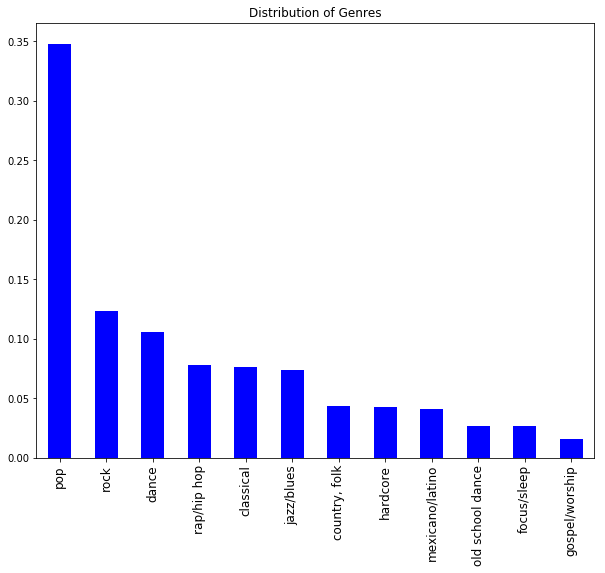

In [78]:
#target genre distribution
plt.xticks(fontsize=12)
df.target.value_counts(normalize=True).plot(kind='bar', figsize=(10, 8), title='Distribution of Genres', color='blue');

In [109]:
df.shape

(35049, 19)

## Range of Features for Each Genre

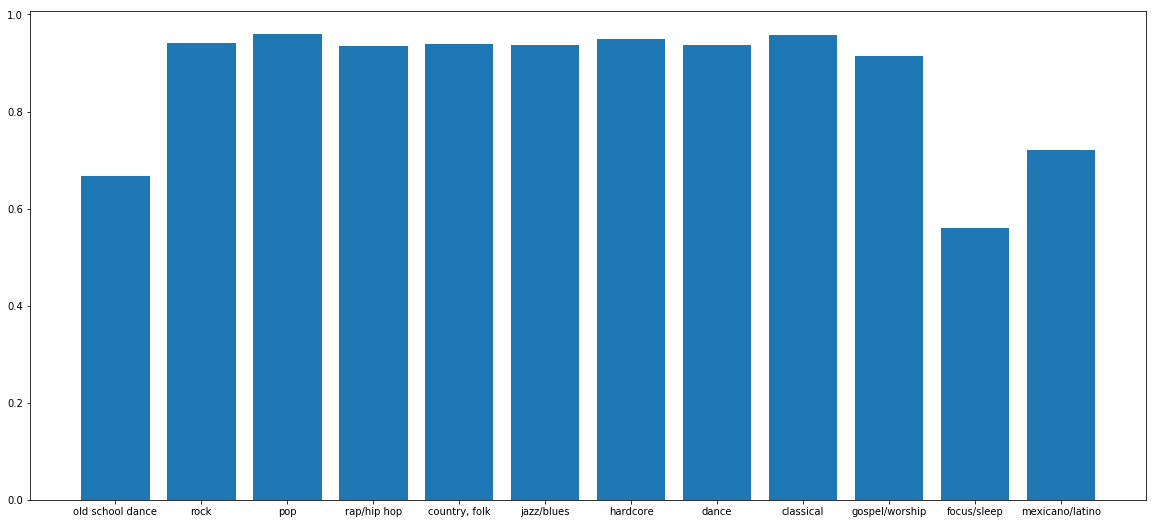

In [209]:
plt.figure(figsize=(20,9))
plt.bar(df.target, df.speechiness)
plt.tight_layout
plt.show();


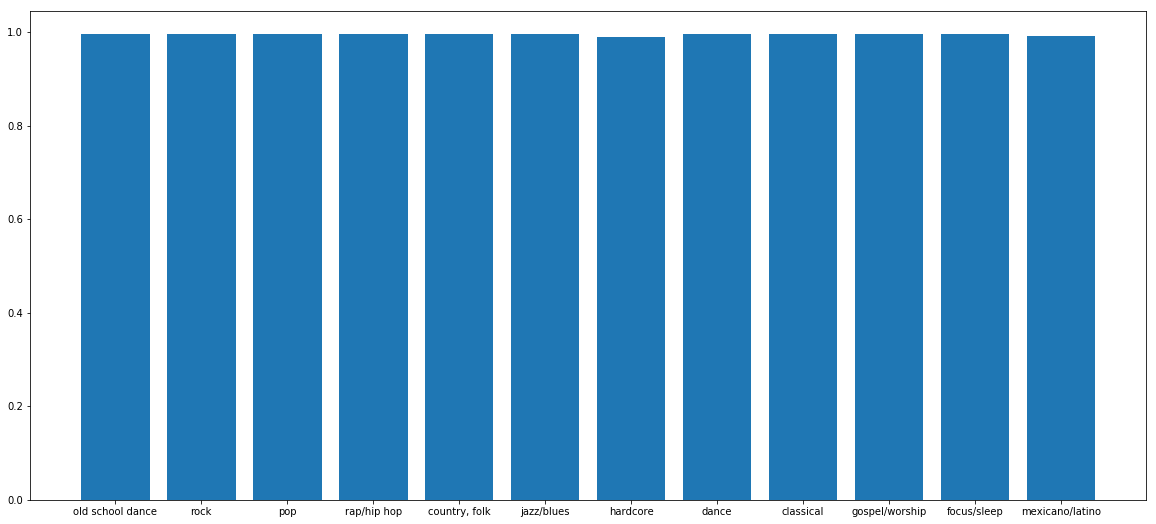

In [10]:
plt.figure(figsize=(20,9))
plt.bar(df.target, df.acousticness)
plt.tight_layout
plt.show();

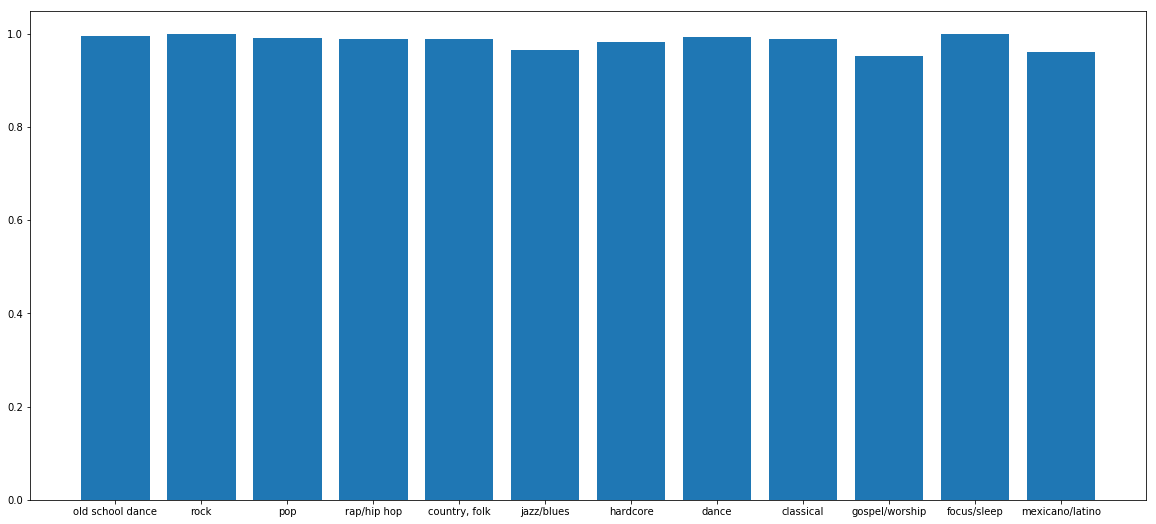

In [11]:
plt.figure(figsize=(20,9))
plt.bar(df.target, df.instrumentalness)
plt.tight_layout
plt.show();

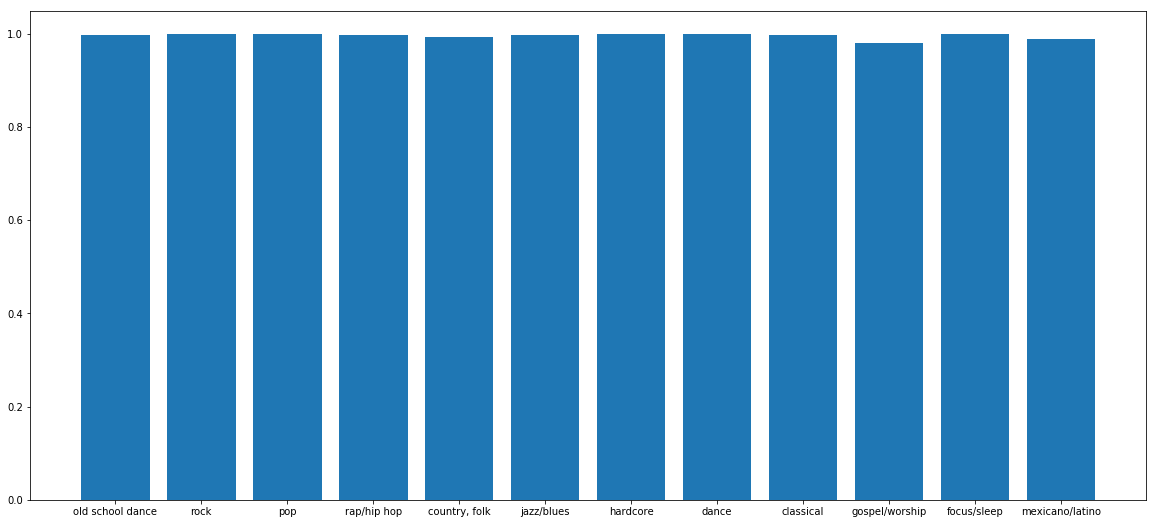

In [12]:
plt.figure(figsize=(20,9))
plt.bar(df.target, df.energy)
plt.tight_layout
plt.show();

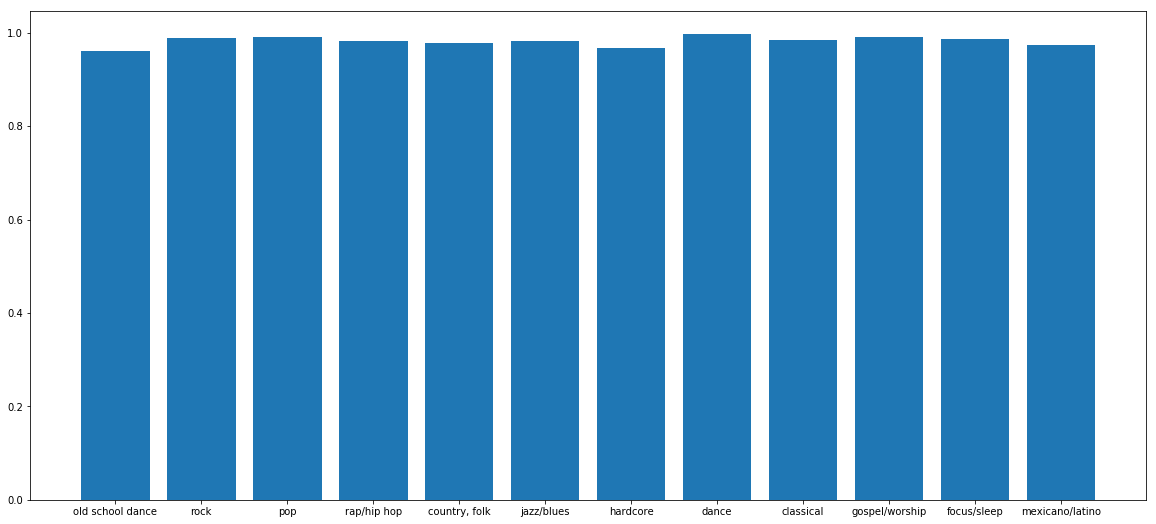

In [13]:
plt.figure(figsize=(20,9))
plt.bar(df.target, df.liveness)
plt.tight_layout
plt.show();

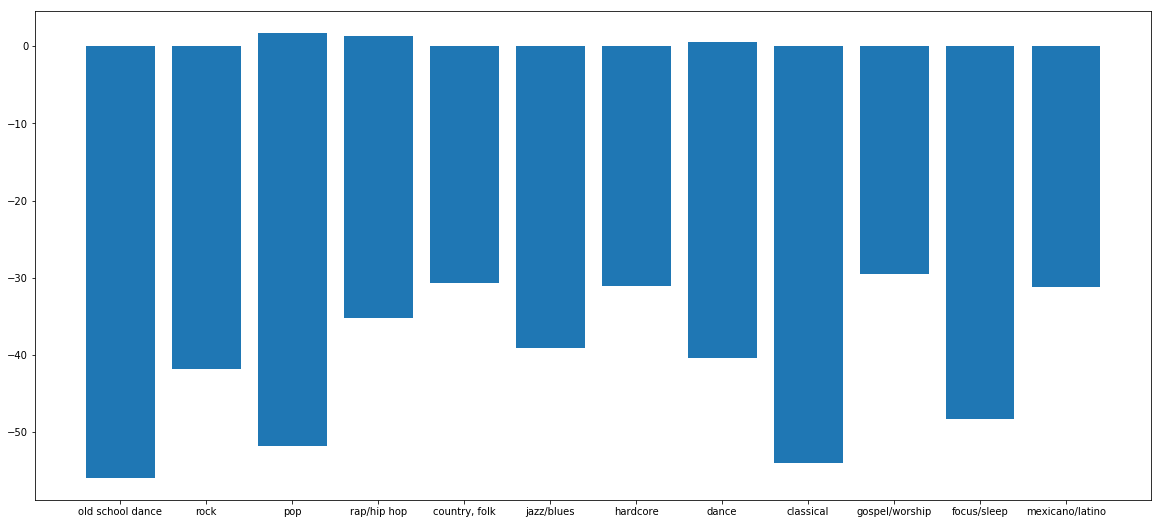

In [14]:
plt.figure(figsize=(20,9))
plt.bar(df.target,df.loudness)
plt.tight_layout
plt.show();

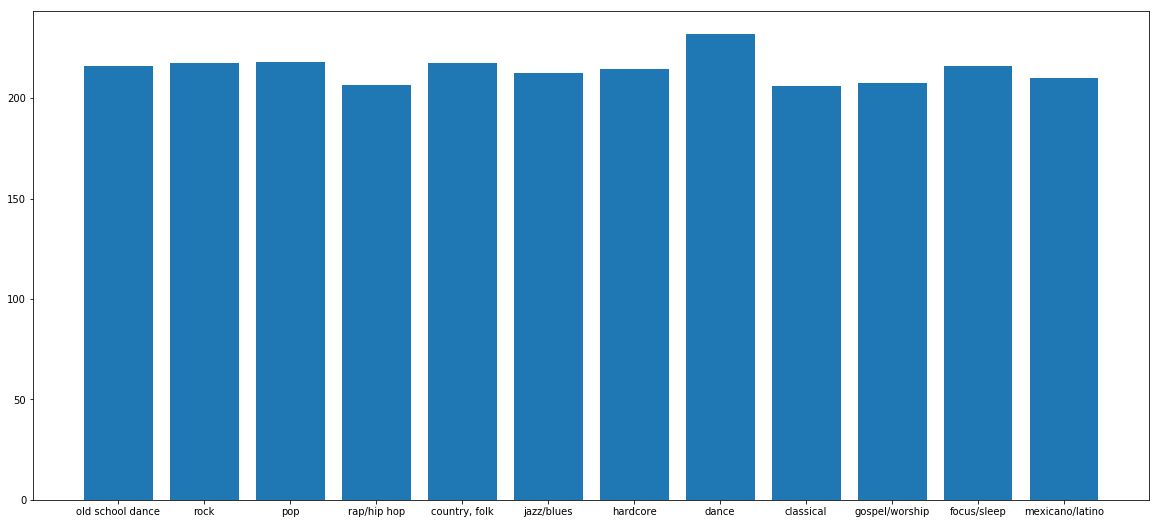

In [15]:
plt.figure(figsize=(20,9))
plt.bar(df.target,df.tempo)
plt.tight_layout
plt.show();

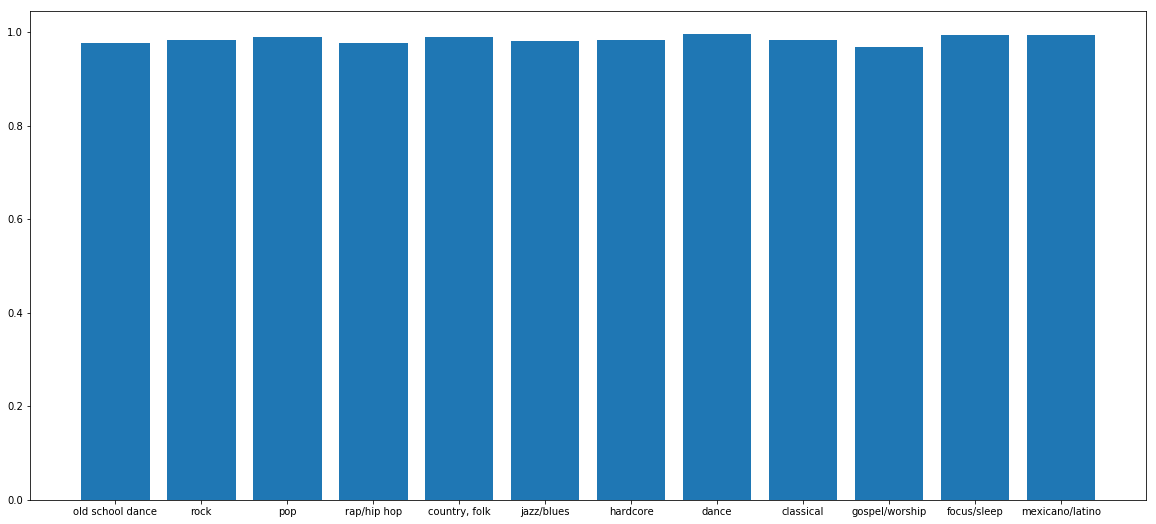

In [16]:
plt.figure(figsize=(20,9))
plt.bar(df.target,df.valence)
plt.tight_layout
plt.show();

In [330]:
#outlier values, not intuitive.
(df.time_signature == 0).sum() 

70

In [18]:
df.time_signature.value_counts()

4    31137
3     2972
5      535
1      335
0       70
Name: time_signature, dtype: int64

In [169]:
#more outliers
(df.tempo == 0).sum()

68

In [19]:
#mode count
df['mode'].value_counts()

1    22225
0    12824
Name: mode, dtype: int64

## Histogram of Features for Each Genre

### Acousticness
Measure of how compressed the song is

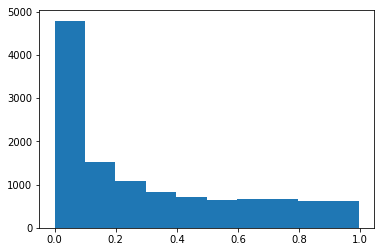

In [20]:
plt.hist(df[df.target=='pop'].acousticness);

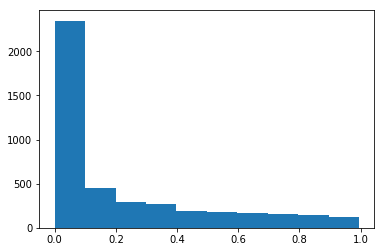

In [21]:
plt.hist(df[df.target=='rock'].acousticness);

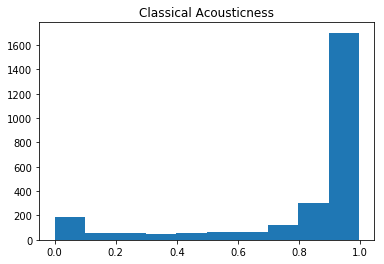

In [79]:
plt.title('Classical Acousticness')
plt.hist(df[df.target=='classical'].acousticness);

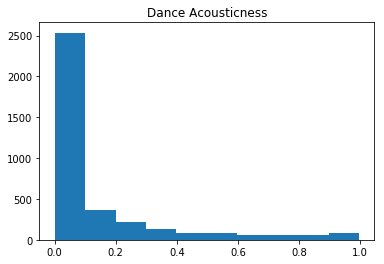

In [80]:
plt.title('Dance Acousticness')
plt.hist(df[df.target=='dance'].acousticness);

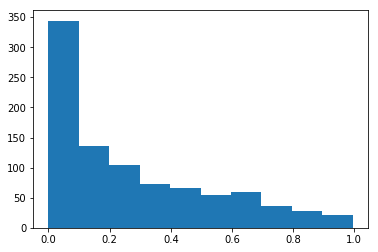

In [24]:
plt.hist(df[df.target=='old school dance'].acousticness);

In [25]:
df.target.unique()

array(['old school dance', 'rock', 'pop', 'rap/hip hop', 'country, folk',
       'jazz/blues', 'hardcore', 'dance', 'classical', 'gospel/worship',
       'focus/sleep', 'mexicano/latino'], dtype=object)

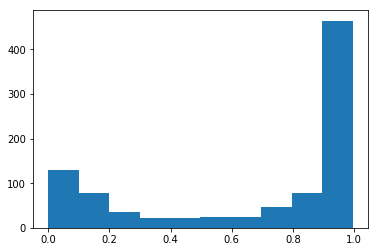

In [26]:
plt.hist(df[df.target=='focus/sleep'].acousticness);

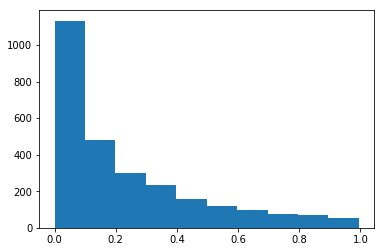

In [27]:
plt.hist(df[df.target=='rap/hip hop'].acousticness);

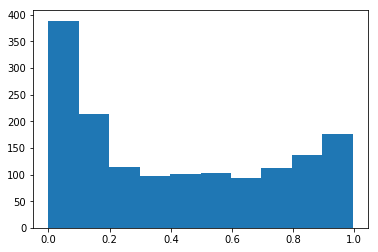

In [28]:
plt.hist(df[df.target=='country, folk'].acousticness);

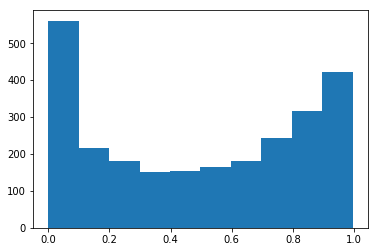

In [29]:
plt.hist(df[df.target=='jazz/blues'].acousticness);

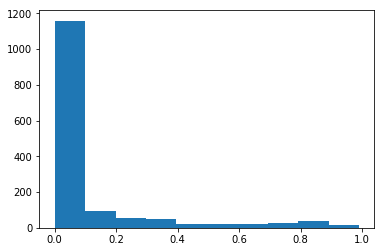

In [30]:
plt.hist(df[df.target=='hardcore'].acousticness);

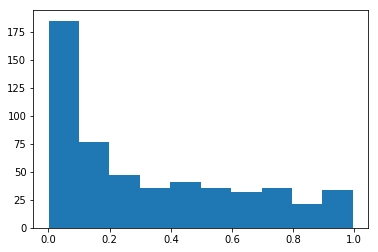

In [31]:
plt.hist(df[df.target=='gospel/worship'].acousticness);

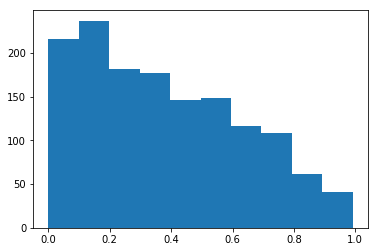

In [32]:
plt.hist(df[df.target=='mexicano/latino'].acousticness);

### Danceability
Measure of a steady beat

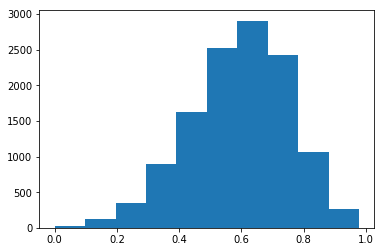

In [33]:
plt.hist(df[df.target=='pop'].danceability);

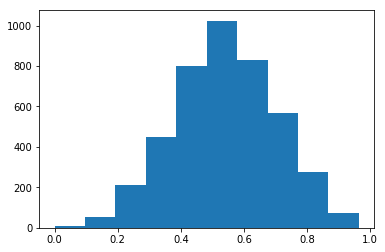

In [34]:
plt.hist(df[df.target=='rock'].danceability);

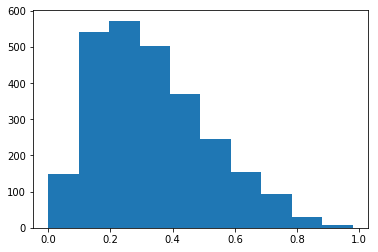

In [35]:
plt.hist(df[df.target=='classical'].danceability);

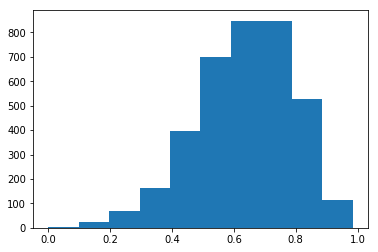

In [36]:
plt.hist(df[df.target=='dance'].danceability);

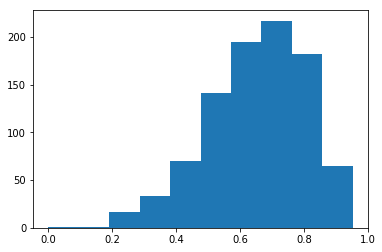

In [37]:
plt.hist(df[df.target=='old school dance'].danceability);

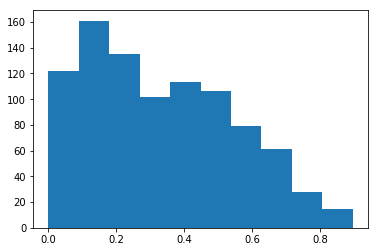

In [39]:
plt.hist(df[df.target=='focus/sleep'].danceability);

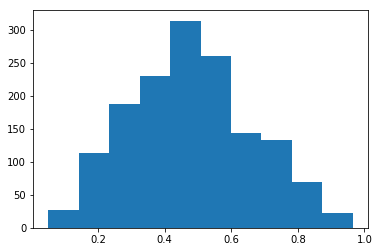

In [40]:
plt.hist(df[df.target=='hardcore'].danceability);

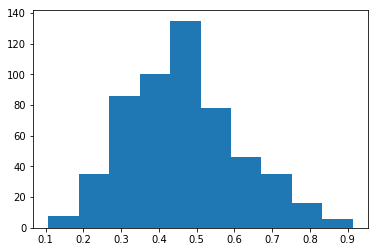

In [41]:
plt.hist(df[df.target=='gospel/worship'].danceability);

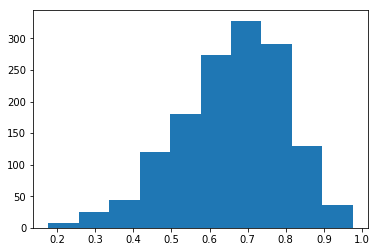

In [42]:
plt.hist(df[df.target=='mexicano/latino'].danceability);

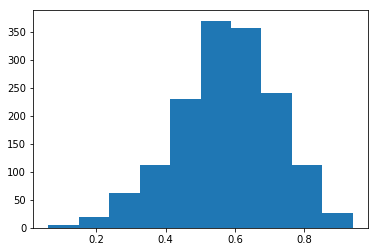

In [44]:
plt.hist(df[df.target=='country, folk'].danceability);

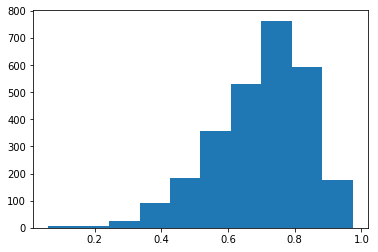

In [45]:
plt.hist(df[df.target=='rap/hip hop'].danceability);

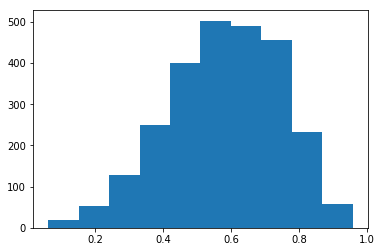

In [75]:
plt.hist(df[df.target=='jazz/blues'].danceability);

### Energy
Measure of busyness

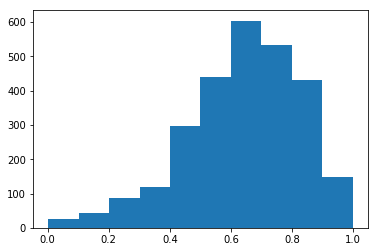

In [46]:
plt.hist(df[df.target=='rap/hip hop'].energy);

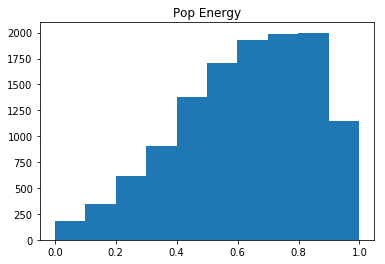

In [81]:
plt.title('Pop Energy')
plt.hist(df[df.target=='pop'].energy);

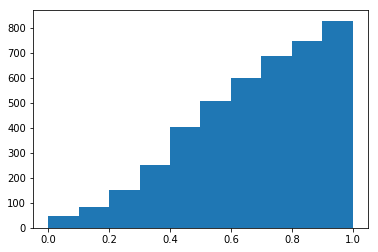

In [48]:
plt.hist(df[df.target=='rock'].energy);

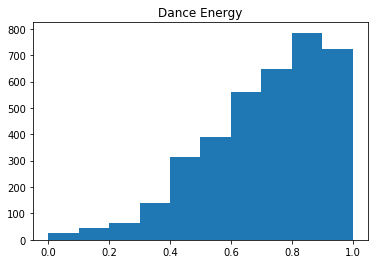

In [80]:
plt.title('Dance Energy')
plt.hist(df[df.target=='dance'].energy);

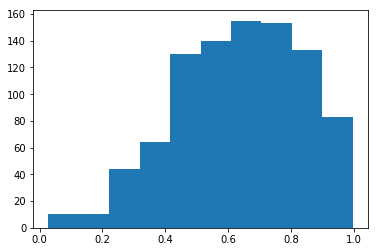

In [50]:
plt.hist(df[df.target=='old school dance'].energy);

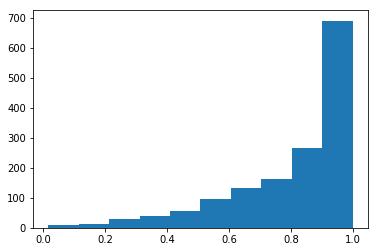

In [51]:
plt.hist(df[df.target=='hardcore'].energy);

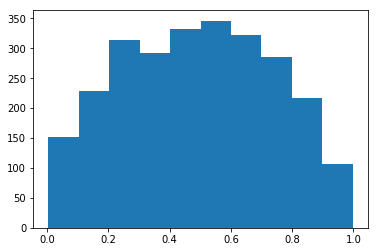

In [52]:
plt.hist(df[df.target=='jazz/blues'].energy);

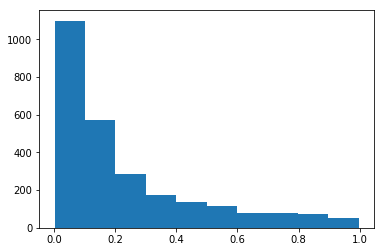

In [53]:
plt.hist(df[df.target=='classical'].energy);

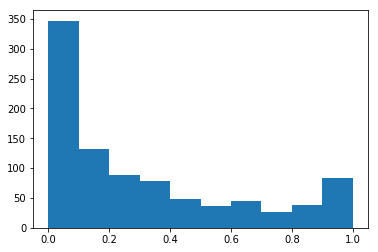

In [54]:
plt.hist(df[df.target=='focus/sleep'].energy);

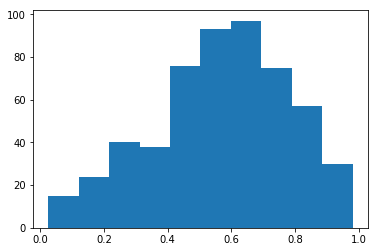

In [55]:
plt.hist(df[df.target=='gospel/worship'].energy);

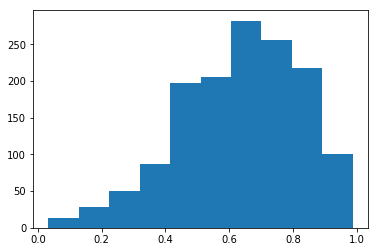

In [56]:
plt.hist(df[df.target=='mexicano/latino'].energy);

### Instrumentalness
Measure of Instrumentation Vowel Sound Prominence

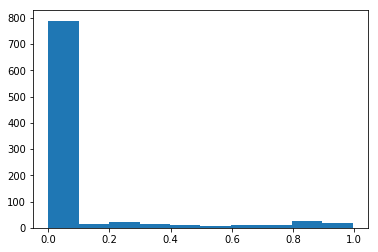

In [60]:
plt.hist(df[df.target=='old school dance'].instrumentalness);

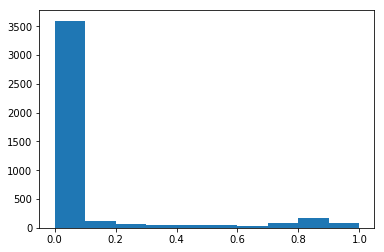

In [61]:
plt.hist(df[df.target=='rock'].instrumentalness);

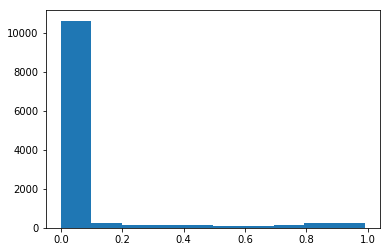

In [62]:
plt.hist(df[df.target=='pop'].instrumentalness);

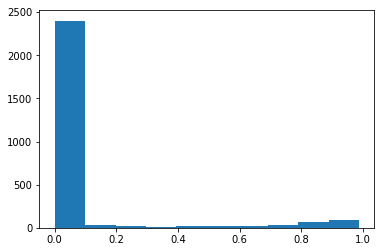

In [63]:
plt.hist(df[df.target=='rap/hip hop'].instrumentalness);

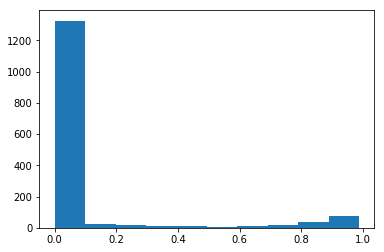

In [64]:
plt.hist(df[df.target=='country, folk'].instrumentalness);

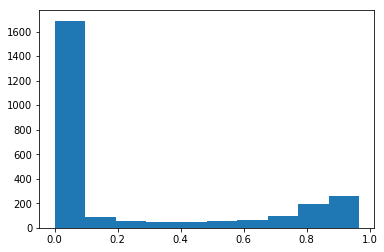

In [65]:
plt.hist(df[df.target=='jazz/blues'].instrumentalness);

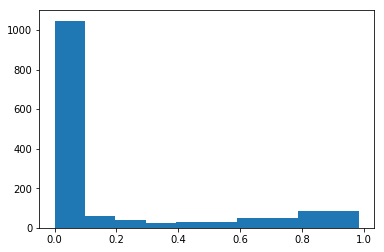

In [67]:
plt.hist(df[df.target=='hardcore'].instrumentalness);

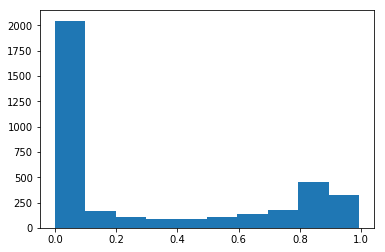

In [68]:
plt.hist(df[df.target=='dance'].instrumentalness);

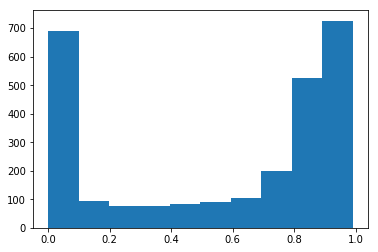

In [69]:
plt.hist(df[df.target=='classical'].instrumentalness);

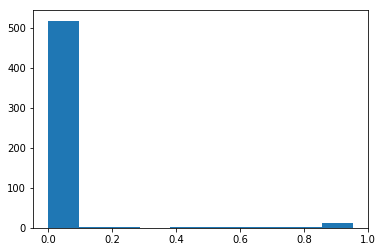

In [70]:
plt.hist(df[df.target=='gospel/worship'].instrumentalness);

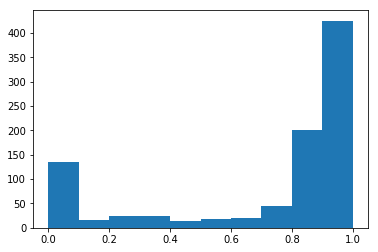

In [71]:
plt.hist(df[df.target=='focus/sleep'].instrumentalness);

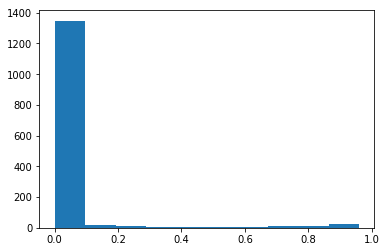

In [72]:
plt.hist(df[df.target=='mexicano/latino'].instrumentalness);

### Liveness
Measure of Audience Noise

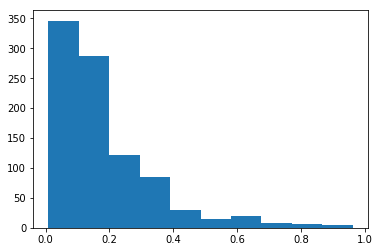

In [77]:
plt.hist(df[df.target=='old school dance'].liveness);

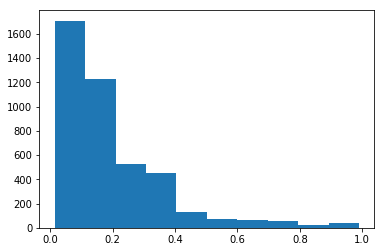

In [78]:
plt.hist(df[df.target=='rock'].liveness);

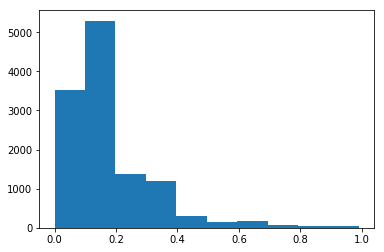

In [79]:
plt.hist(df[df.target=='pop'].liveness);

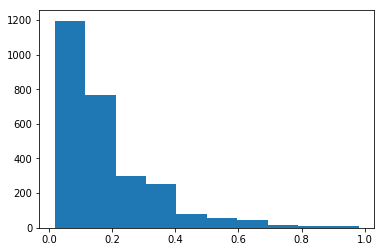

In [80]:
plt.hist(df[df.target=='rap/hip hop'].liveness);

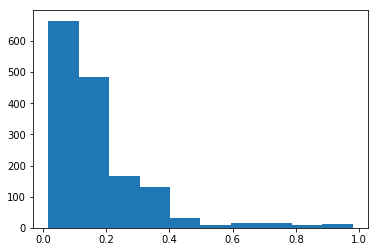

In [81]:
plt.hist(df[df.target=='country, folk'].liveness);

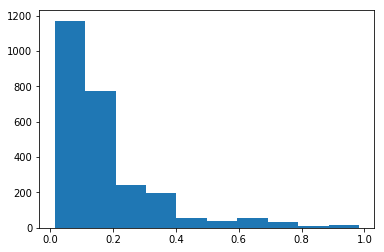

In [82]:
plt.hist(df[df.target=='jazz/blues'].liveness);

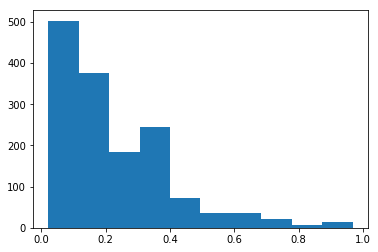

In [84]:
plt.hist(df[df.target=='hardcore'].liveness);

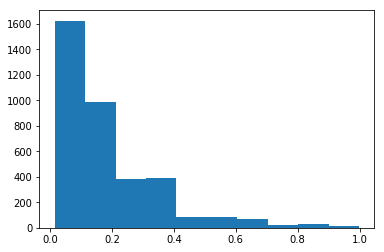

In [85]:
plt.hist(df[df.target=='dance'].liveness);

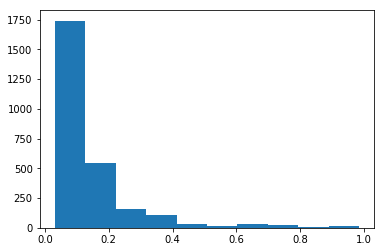

In [86]:
plt.hist(df[df.target=='classical'].liveness);

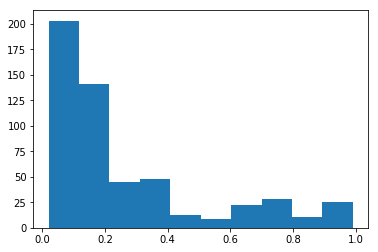

In [87]:
plt.hist(df[df.target=='gospel/worship'].liveness);

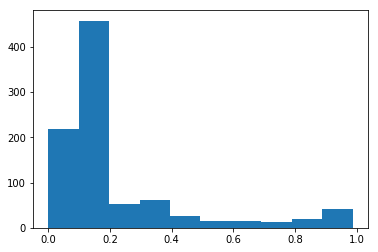

In [88]:
plt.hist(df[df.target=='focus/sleep'].liveness);

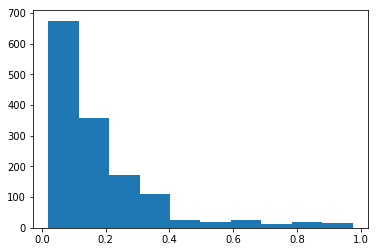

In [89]:
plt.hist(df[df.target=='mexicano/latino'].liveness);

### Loudness
Change in sound pressure measured in decibels

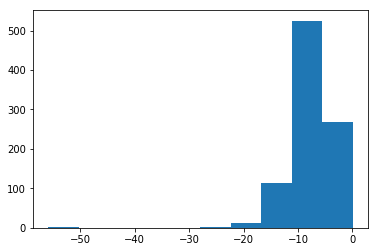

In [91]:
plt.hist(df[df.target=='old school dance'].loudness);

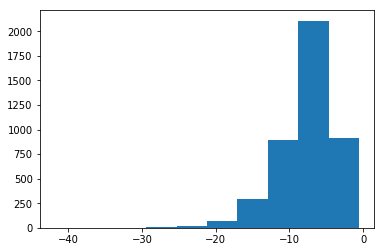

In [92]:
plt.hist(df[df.target=='rock'].loudness);

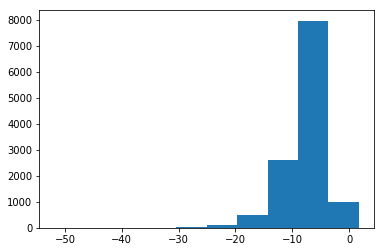

In [93]:
plt.hist(df[df.target=='pop'].loudness);

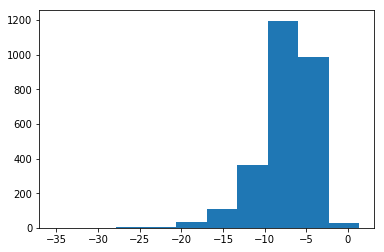

In [94]:
plt.hist(df[df.target=='rap/hip hop'].loudness);

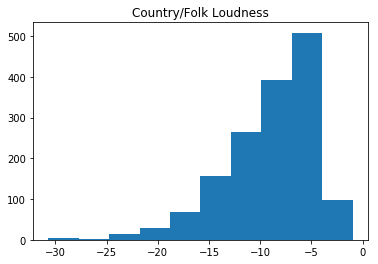

In [82]:
plt.title('Country/Folk Loudness')
plt.hist(df[df.target=='country, folk'].loudness);

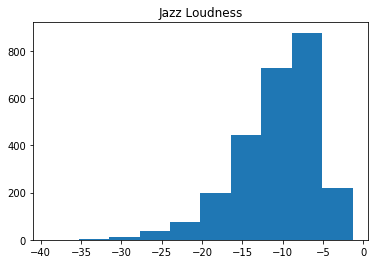

In [83]:
plt.title('Jazz Loudness')
plt.hist(df[df.target=='jazz/blues'].loudness);

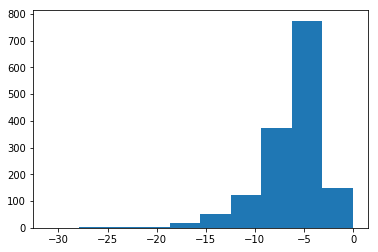

In [98]:
plt.hist(df[df.target=='hardcore'].loudness);

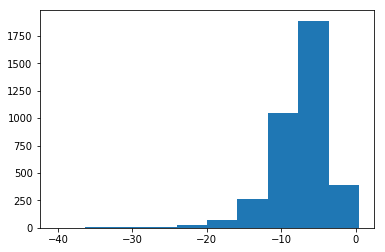

In [99]:
plt.hist(df[df.target=='dance'].loudness);

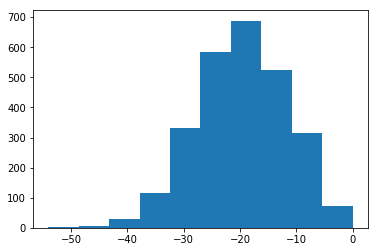

In [100]:
plt.hist(df[df.target=='classical'].loudness);

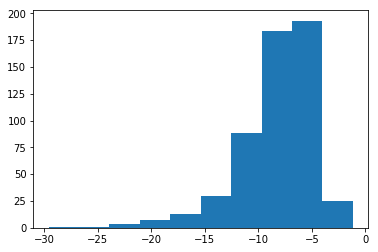

In [101]:
plt.hist(df[df.target=='gospel/worship'].loudness);

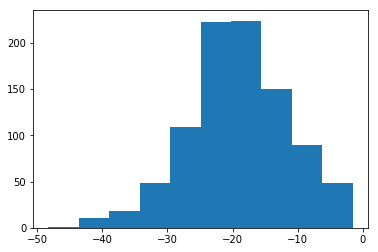

In [102]:
plt.hist(df[df.target=='focus/sleep'].loudness);

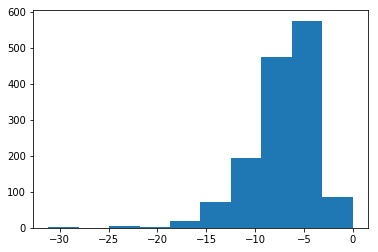

In [103]:
plt.hist(df[df.target=='mexicano/latino'].loudness);

### Speechiness
Measure of Non-Vowel Sounds

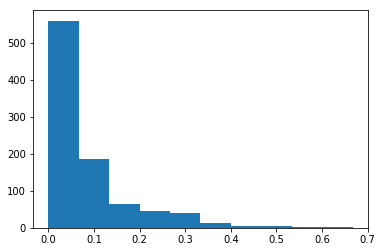

In [105]:
plt.hist(df[df.target=='old school dance'].speechiness);

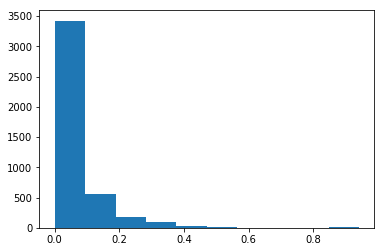

In [106]:
plt.hist(df[df.target=='rock'].speechiness);

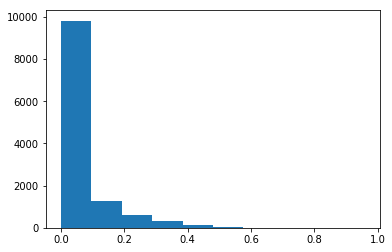

In [107]:
plt.hist(df[df.target=='pop'].speechiness);

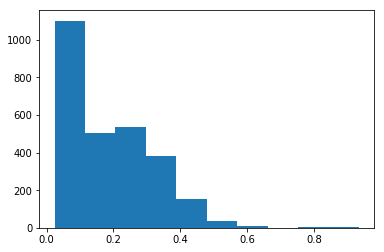

In [108]:
plt.hist(df[df.target=='rap/hip hop'].speechiness);

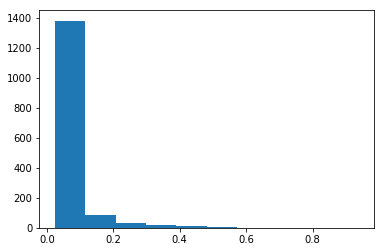

In [109]:
plt.hist(df[df.target=='country, folk'].speechiness);

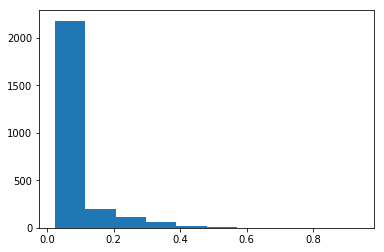

In [110]:
plt.hist(df[df.target=='jazz/blues'].speechiness);

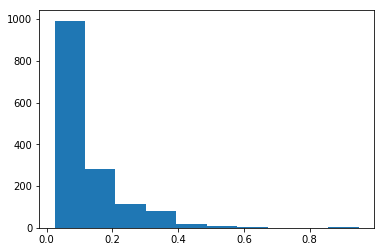

In [111]:
plt.hist(df[df.target=='hardcore'].speechiness);

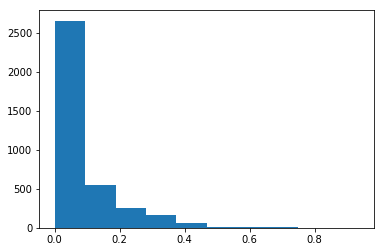

In [112]:
plt.hist(df[df.target=='dance'].speechiness);

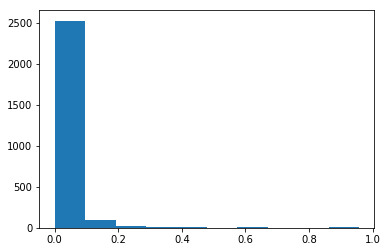

In [113]:
plt.hist(df[df.target=='classical'].speechiness);

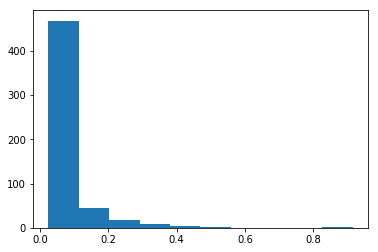

In [114]:
plt.hist(df[df.target=='gospel/worship'].speechiness);

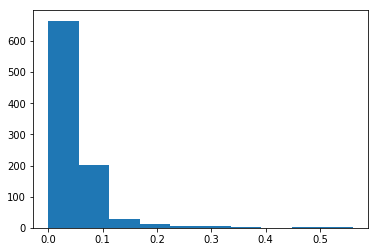

In [115]:
plt.hist(df[df.target=='focus/sleep'].speechiness);

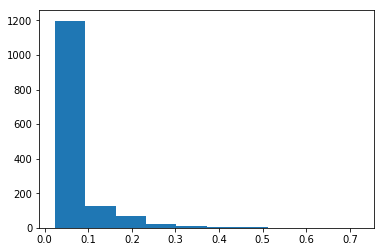

In [116]:
plt.hist(df[df.target=='mexicano/latino'].speechiness);

### Tempo
Measure of Speed of song in beats per minute

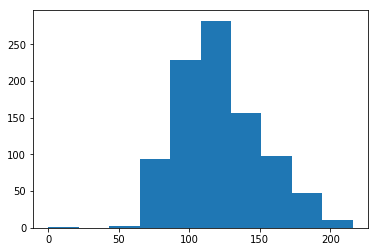

In [118]:
plt.hist(df[df.target=='old school dance'].tempo);

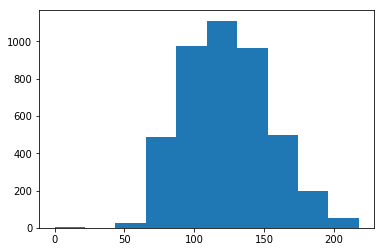

In [119]:
plt.hist(df[df.target=='rock'].tempo);

In [168]:
# more outliers
(df[df.target=='rock'].tempo == 0).sum()

3

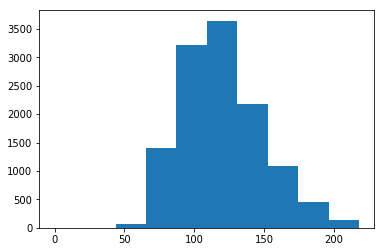

In [120]:
plt.hist(df[df.target=='pop'].tempo);

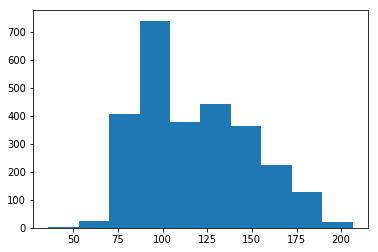

In [121]:
plt.hist(df[df.target=='rap/hip hop'].tempo);

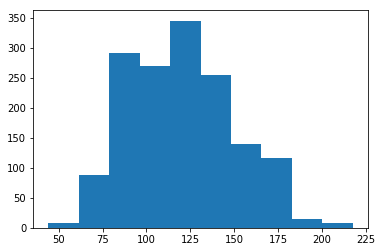

In [122]:
plt.hist(df[df.target=='country, folk'].tempo);

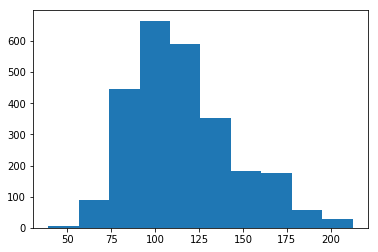

In [123]:
plt.hist(df[df.target=='jazz/blues'].tempo);

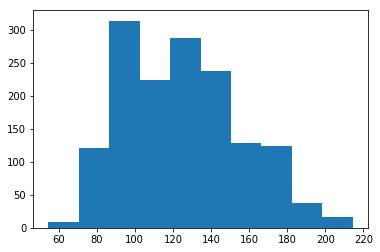

In [124]:
plt.hist(df[df.target=='hardcore'].tempo);

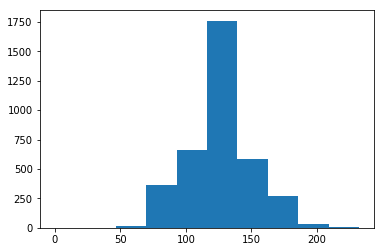

In [125]:
plt.hist(df[df.target=='dance'].tempo);

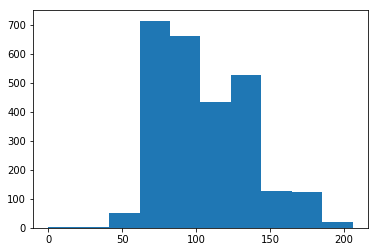

In [126]:
plt.hist(df[df.target=='classical'].tempo);

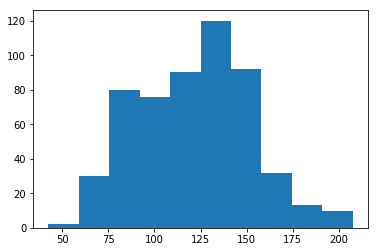

In [127]:
plt.hist(df[df.target=='gospel/worship'].tempo);

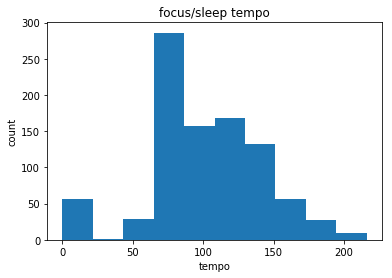

In [11]:
plt.xlabel('tempo')
plt.ylabel('count')
plt.title('focus/sleep tempo')
plt.hist(df[df.target=='focus/sleep'].tempo);

In [134]:
(df.tempo == 0).sum() 

68

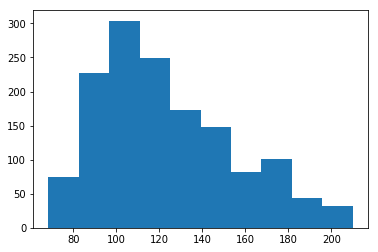

In [135]:
plt.hist(df[df.target=='mexicano/latino'].tempo);

 ### Valence
 Measure of Posivity in a Song

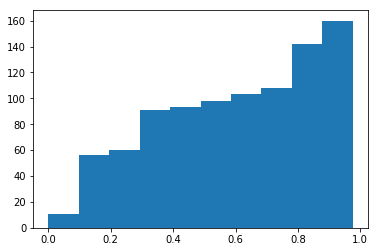

In [152]:
plt.hist(df[df.target=='old school dance'].valence);

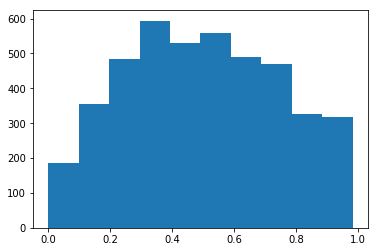

In [153]:
plt.hist(df[df.target=='rock'].valence);

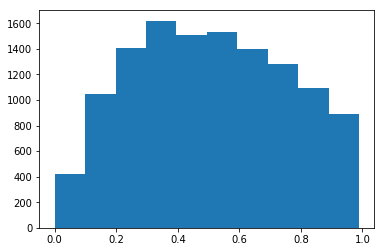

In [154]:
plt.hist(df[df.target=='pop'].valence);

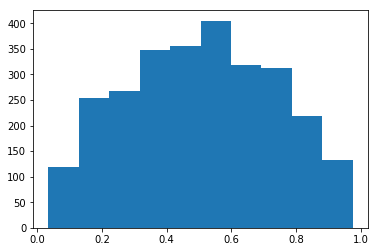

In [155]:
plt.hist(df[df.target=='rap/hip hop'].valence);

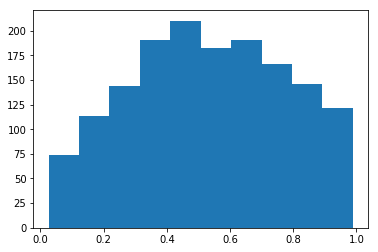

In [156]:
plt.hist(df[df.target=='country, folk'].valence);

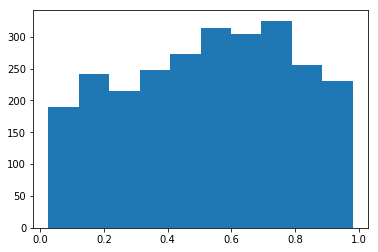

In [157]:
plt.hist(df[df.target=='jazz/blues'].valence);

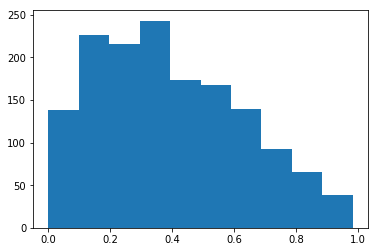

In [161]:
plt.hist(df[df.target=='hardcore'].valence);

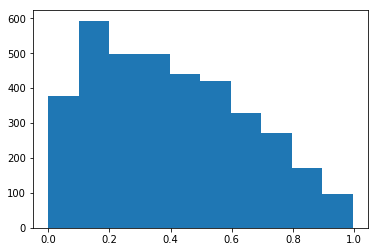

In [162]:
plt.hist(df[df.target=='dance'].valence);

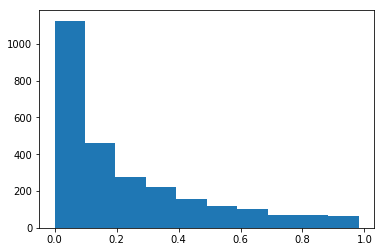

In [163]:
plt.hist(df[df.target=='classical'].valence);

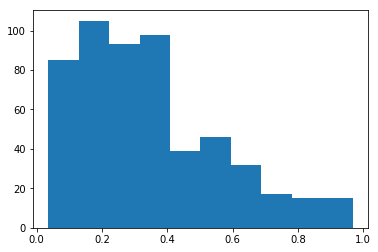

In [164]:
plt.hist(df[df.target=='gospel/worship'].valence);

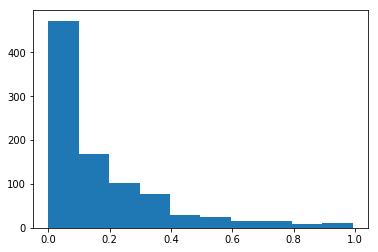

In [165]:
plt.hist(df[df.target=='focus/sleep'].valence);

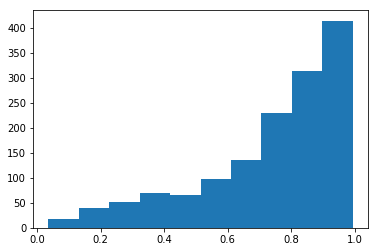

In [6]:
plt.hist(df[df.target=='mexicano/latino'].valence);

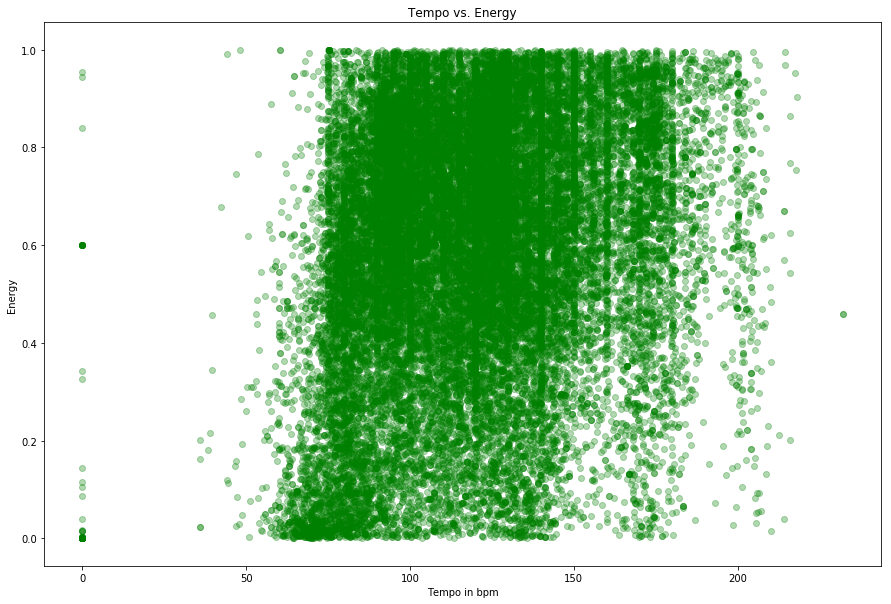

In [5]:
#investigation of correaltion
plt.figure(figsize=(15,10))
plt.scatter(df.tempo, df.energy,c='g', alpha=0.3)
plt.xlabel('Tempo in bpm')
plt.ylabel('Energy')
plt.title('Tempo vs. Energy')
plt.show()

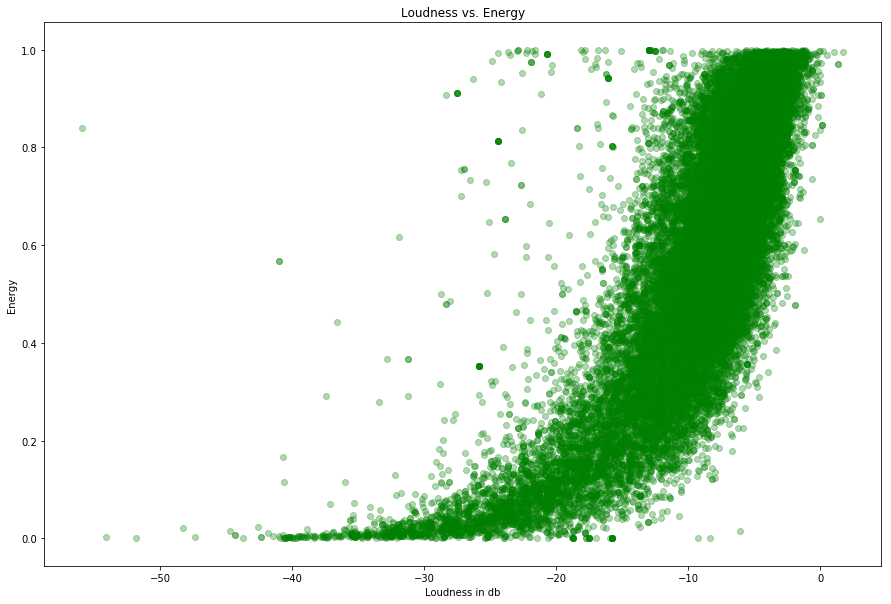

In [6]:
#investigation of correaltion
plt.figure(figsize=(15,10))
plt.scatter(df.loudness, df.energy,c='g', alpha=0.3)
plt.xlabel('Loudness in db')
plt.ylabel('Energy')
plt.title('Loudness vs. Energy')
plt.show()

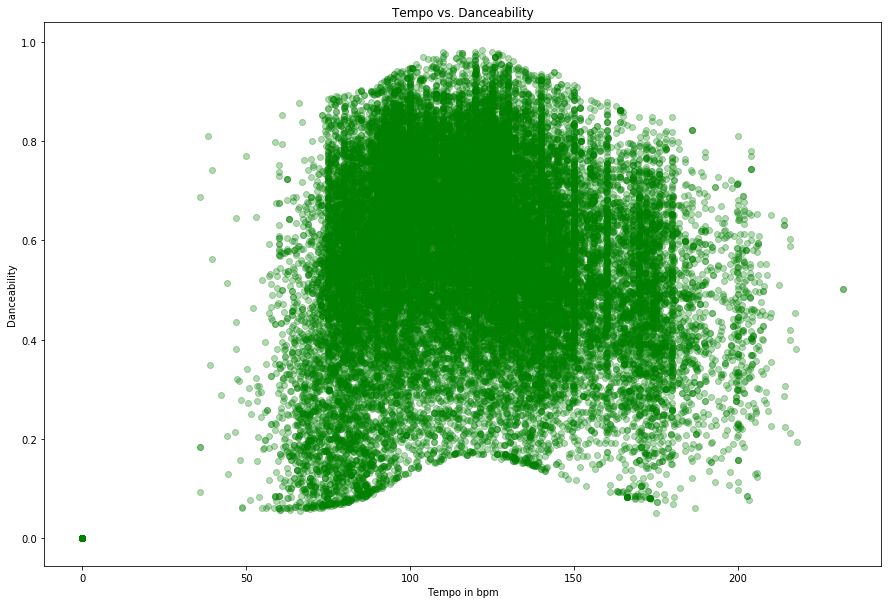

In [7]:
#investigation of correaltion
plt.figure(figsize=(15,10))
plt.scatter(df.tempo, df.danceability,c='g', alpha=0.3)
plt.xlabel('Tempo in bpm')
plt.ylabel('Danceability')
plt.title('Tempo vs. Danceability')
plt.show()

### Outliers
One of the more curious cases were the data points with a zero for time siganture and/or tempo. These in fact were not songs at all, but more along the lines of sound effects, noises to aid in sleep or ambient soundscape music. These examples were most prevalent in the focus/sleep target genre

In [6]:
# these tracks represent a majority of sleep tracks, ex. white noise, nature sounds
df.loc[df.time_signature == 0]
df.loc[df.tempo == 0].head()

,acousticness,artist_name,artist_uri,danceability,energy,genre,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,track_id,track_name,valence,target
1140,0.119,Ambient Rain,spotify:artist:5nSGBmlgUdqWNExnOX8VtV,0.0,0.601000,['sleep'],0.771,11,0.968,-13.753,0,69,0.0,0.0,0,7dTyZl4cBRKnPBeq1fdrHY,White Noise,0.0,focus/sleep
1796,0.000,Art Of Noise,spotify:artist:1XqT7nMi7H4WDGdzurdh0r,0.0,0.000000,"['acid house', 'dance rock', 'electronic', 'ne...",0.000,11,0.000,-51.835,0,51,0.0,0.0,0,2lF8i11YFtllDacDlFnKqU,Hi Cut Brown Noise,0.0,pop
1890,0.865,Asmr,spotify:artist:7nR813jWFgkPsXs1GjrzZk,0.0,0.000345,['sleep'],0.263,11,0.104,-23.931,1,49,0.0,0.0,0,1sku0BerKMi7ZumZkIebJ5,ASMR : Big Fan Noise (REM Sleep),0.0,focus/sleep
1891,0.865,ASMR HD,spotify:artist:7nR813jWFgkPsXs1GjrzZk,0.0,0.000345,['sleep'],0.263,11,0.104,-23.931,1,49,0.0,0.0,0,1sku0BerKMi7ZumZkIebJ5,ASMR : Big Fan Noise (REM Sleep),0.0,focus/sleep
2210,0.791,Baby Sweet Dream,spotify:artist:2c5WYCqQGs0UttiLCzVfOe,0.0,0.003420,['sleep'],1.000,11,0.111,-28.460,1,60,0.0,0.0,0,2ifiCzo5SSPeWbPIUdvSPA,White Noise - Loopable With No Fade,0.0,focus/sleep


# Modeling
A number of different classification models were used to predict 12 target genres. In order to make these targets applicable for modeling some preprocessing was utilized. In this case label encoder was utilized to make every genre from 0-11 in alphabetical order, so classical music was represented with a 0 and rock music was represented with an 11. The data was than split into a training, validation and a testing set to simulate how a model would perform on unseen data. Using various models to fit on the training set, tune on the validation set and finally score on the testing set. The metric utilized for optimization for the most part was accuracy, though a few other metrics were investigated. 

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,  train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier

In [4]:
# make a target, y
y = df['target']

In [5]:
#transform y, 0-11 utilizing label encoder
le = LabelEncoder()
y = le.fit_transform(y)


In [6]:
#features
X = df[['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]
X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.5710,0.641,0.665,0.001070,0.159,-7.839,1,0.0263,138.017,4,0.677
1,0.1220,0.796,0.513,0.000000,0.150,-7.140,0,0.4520,75.018,4,0.235
2,0.2290,0.792,0.256,0.548000,0.350,-12.525,1,0.1910,87.774,4,0.563
3,0.0375,0.703,0.696,0.000006,0.274,-5.482,1,0.0529,121.969,4,0.366
4,0.8830,0.610,0.258,0.014500,0.103,-12.758,1,0.0331,127.080,4,0.164


In [7]:
#check correlations
abs(pd.concat([X, pd.Series(y)], axis=1).corr()[0]).sort_values(ascending = False)

0                   1.000000
instrumentalness    0.379643
loudness            0.378182
energy              0.259972
acousticness        0.252489
valence             0.248648
danceability        0.241037
speechiness         0.095714
time_signature      0.092222
tempo               0.075416
liveness            0.014123
mode                0.008088
Name: 0, dtype: float64

In [8]:
#how the lables work in label encoder, alphabetical
list(zip(np.unique(y), np.unique(le.inverse_transform(y))))

/Users/scottsanowitz/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[(0, 'classical'),
 (1, 'country, folk'),
 (2, 'dance'),
 (3, 'focus/sleep'),
 (4, 'gospel/worship'),
 (5, 'hardcore'),
 (6, 'jazz/blues'),
 (7, 'mexicano/latino'),
 (8, 'old school dance'),
 (9, 'pop'),
 (10, 'rap/hip hop'),
 (11, 'rock')]

In [9]:
#form, training, validating, and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=24)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(19714, 11)
(6572, 11)
(19714,)
(6572,)


# Random Forest

A tree method seemed intuitive in predicting genres based on impurity splits. The model's hyperparameter were optimized using Randomized Search Cross Validation. Realizing the model's performance improved with more trees, the n_estimators were than set to 5000, this improved the score but slowed down my model considerably. I tried more than 5000 trees and sometimes my model would produce even better scores, but alot of the time my kernel would die, so 5000 was chosen for its consistency. Random Forest has a great attribute in feature importance which show what features were most effective at getting splits with the lowest impurity.

In [34]:
# pipeline with random forest to be randomized search
pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state= 24))
])

In [35]:
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.44004869141813757

In [22]:
#parameters to iterate over
params = {
    'rf__n_estimators':[1, 10,25, 50, 100, 500, 1000],
    'rf__max_features':[None,"sqrt", "log2"]
}

In [23]:
# randomized search cross validation
rs = RandomizedSearchCV(pipe, param_distributions=params,scoring='accuracy', random_state=24 )

In [24]:
rs.fit(X_train, y_train)


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'rf__n_estimators': [1, 10, 25, 50, 100, 500, 1000], 'rf__max_features': [None, 'sqrt', 'log2']},
          pre_dispatch='2*n_jobs', random_state=24, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [25]:
print('best_params:',rs.best_params_)
print('best score:',rs.best_score_)

best_params: {'rf__n_estimators': 1000, 'rf__max_features': 'sqrt'}
best score: 0.481663242791


In [18]:
# More trees(n_estiamtors) better score
rf = RandomForestClassifier(n_estimators=5_000, max_features = 'sqrt', random_state=24)

In [19]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

In [20]:
rf.score(X_train, y_train)

0.9821446687633154

In [21]:
rf.score(X_val, y_val)

0.4838709677419355

In [22]:
rf.score(X_test, y_test)

0.49480771425310965

In [23]:
s = sorted(list(zip(rf.feature_importances_, X.columns )), reverse=True)

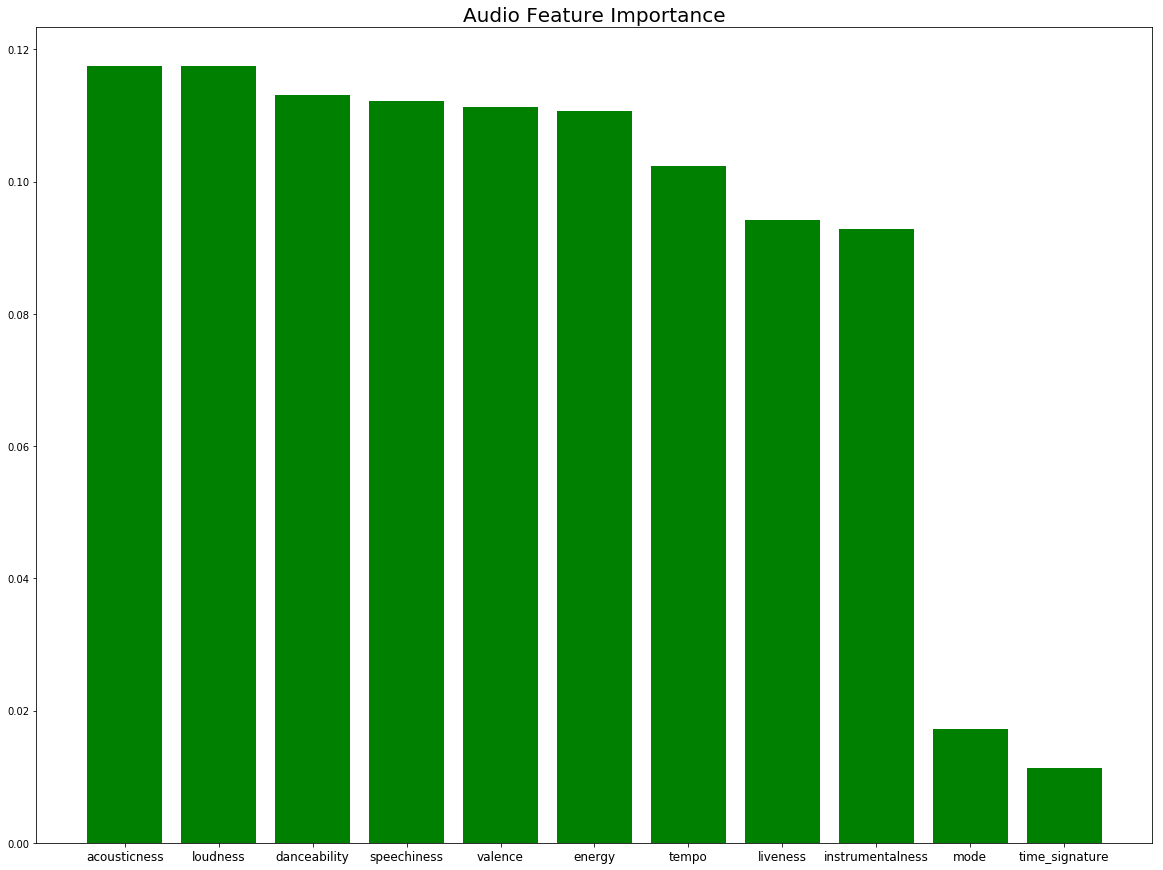

In [24]:
#graph feature importance

plt.figure(figsize=(20, 15))
plt.title('Audio Feature Importance', fontsize=20)
sy = [y[0] for y in s]
sx = [x[1] for x in s]
plt.bar(sx, sy, color ='g')
plt.xticks(fontsize=12)
plt.tight_layout
plt.show()

In [25]:
# predicted target values
y_hat = rf.predict(X_test)

In [111]:
#for classification report to have original targets
target_names = ['classical', 'country/folk', 'dance', 'focus/sleep', 'gospel/worship', 'hardcore',
               'jazz/blues', 'mexicano/latino', 'old school dance', 'pop', 'rap/hip hop', 'rock']

In [27]:
# Look at more metrics
print(classification_report(y_test, y_hat, target_names=target_names))

                  precision    recall  f1-score   support

       classical       0.62      0.74      0.67       666
    country/folk       0.59      0.07      0.12       384
           dance       0.58      0.44      0.50       924
     focus/sleep       0.70      0.39      0.50       231
  gospel/worship       0.56      0.17      0.26       136
        hardcore       0.48      0.26      0.34       375
      jazz/blues       0.41      0.23      0.30       648
 mexicano/latino       0.53      0.17      0.26       359
old school dance       0.59      0.07      0.12       231
             pop       0.47      0.82      0.59      3050
     rap/hip hop       0.48      0.42      0.45       682
            rock       0.47      0.18      0.26      1077

     avg / total       0.51      0.49      0.45      8763



In [27]:
#Predicted Distribution
pd.Series(le.inverse_transform(y_hat)).value_counts(normalize=True)

pop                 0.600365
classical           0.089467
dance               0.084788
rap/hip hop         0.069040
rock                0.051923
jazz/blues          0.041995
hardcore            0.020883
focus/sleep         0.014607
mexicano/latino     0.013352
country, folk       0.006162
gospel/worship      0.004108
old school dance    0.003309
dtype: float64

In [28]:
# Actual Distribution
pd.Series(le.inverse_transform(y_test)).value_counts(normalize=True)

pop                 0.348054
rock                0.122903
dance               0.105443
rap/hip hop         0.077827
classical           0.076001
jazz/blues          0.073947
country, folk       0.043821
hardcore            0.042794
mexicano/latino     0.040968
old school dance    0.026361
focus/sleep         0.026361
gospel/worship      0.015520
dtype: float64

# Weighted Random Forest

Noticing my previous random forest was predicting too many of the majority class and penalizing all the minority classes, I decided to alleviate it with a weighted random forest. Out of two different weightings, the class weight norm out perfomed the class weight predicted. The class weights were calculated by using the class distributions. For example, in the actual distribution there are 4.5 pop songs for every classical song, so classical gets a 4.5 times weighting. In the predicted distribution there are 6.7 pop songs for every classical song, so classical gets a 6.7 weighting ditribution. Pop, being the majority class always get a class weighting of 1.  Though it did not have the desired effect learning and experimenting with class weighting was worth it.

In [21]:
#ratio between majority class to other class, pop is class 9 so 9:1, so for 1 rock song how many pop songs and so on?
class_weight_norm ={0:4.5, 1:8, 2:3.3, 3:13.5, 4:23.3, 5:8.1, 6:4.7, 7:8.5, 8:13.5, 9:1, 10:5, 11:2.8}
class_weight_pred ={0:6.7, 1:100, 2:7.1, 3:42.8, 4:150, 5:30, 6:14.3, 7:46.2, 8:200, 9:1, 10:8.7, 11:11.5}

In [22]:
rf_weighted = RandomForestClassifier(n_estimators=1000, max_features='sqrt', class_weight=class_weight_norm, random_state=24)

In [23]:
rf_weighted.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True,
            class_weight={0: 4.5, 1: 8, 2: 3.3, 3: 13.5, 4: 23.3, 5: 8.1, 6: 4.7, 7: 8.5, 8: 13.5, 9: 1, 10: 5, 11: 2.8},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=24,
            verbose=0, warm_start=False)

In [24]:
rf_weighted.score(X_val, y_val)

0.4847839318320146

In [25]:
rf_weighted.score(X_test, y_test)

0.48978660276161134

In [26]:
s = sorted(list(zip(rf_weighted.feature_importances_, X.columns )), reverse=True)

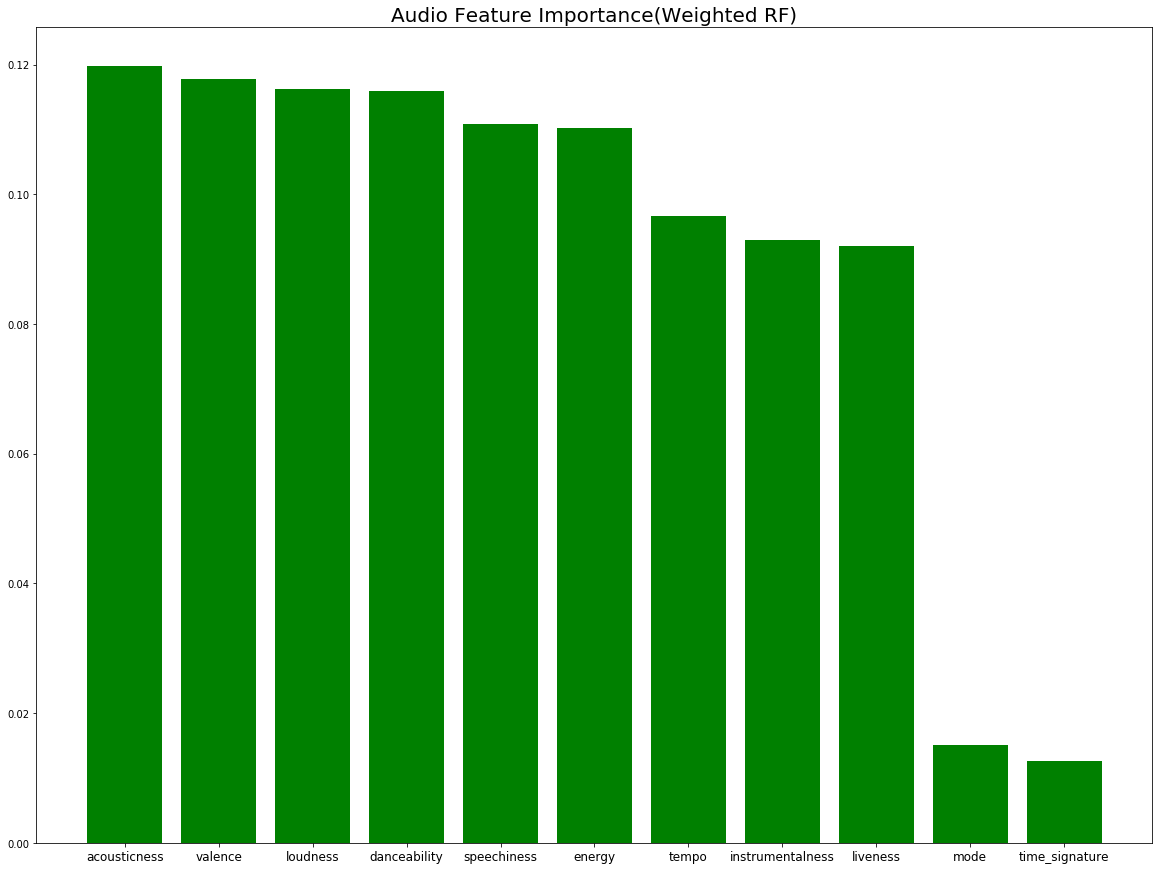

In [27]:
plt.figure(figsize=(20, 15))
plt.title('Audio Feature Importance(Weighted RF)', fontsize=20)
sy = [y[0] for y in s]
sx = [x[1] for x in s]
plt.bar(sx, sy, color ='g')
plt.xticks(fontsize=12)
plt.tight_layout
plt.show()

In [59]:
y_hat_w = rf_weighted.predict(X_test)

In [60]:
print(classification_report(y_test, y_hat_w, target_names=target_names))

                  precision    recall  f1-score   support

       classical       0.62      0.74      0.67       666
    country/folk       0.63      0.07      0.13       384
           dance       0.58      0.43      0.50       924
     focus/sleep       0.72      0.36      0.48       231
  gospel/worship       0.56      0.18      0.27       136
        hardcore       0.45      0.25      0.32       375
      jazz/blues       0.43      0.21      0.28       648
 mexicano/latino       0.62      0.18      0.28       359
old school dance       0.53      0.07      0.13       231
             pop       0.46      0.83      0.59      3050
     rap/hip hop       0.47      0.39      0.42       682
            rock       0.47      0.15      0.23      1077

     avg / total       0.51      0.49      0.44      8763



In [104]:
#predicted distribution
pd.Series(le.inverse_transform(y_hat_w)).value_counts(normalize=True)

pop                 0.623531
classical           0.090951
dance               0.078055
rap/hip hop         0.062992
rock                0.046674
jazz/blues          0.034805
hardcore            0.023051
focus/sleep         0.014265
mexicano/latino     0.011183
country, folk       0.006276
gospel/worship      0.004336
old school dance    0.003880
dtype: float64

# Logistic Regression
Logistic Regression has a great interpretabilty feature in that it calculates betas used in fitting the training data. Though this model did not produce the best score, it produced great graphs of what features are prominent in a genre. A Grid Search Cross Validation was used to optimize the hyperparameters. 

In [120]:
pipe = Pipeline([
    ('lr', LogisticRegression())
])

In [121]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [122]:
pipe.score(X_val, y_val)

0.4286366402921485

In [123]:
pipe.score(X_test, y_test)

0.42987561337441516

In [124]:
params = {
    'lr__penalty':['l1','l2'],
    'lr__C':[.1, 1, 10],
    'lr__warm_start':[False, True]
}

In [125]:
#Grid Search Cross Validation, used for optimzing hyperparameters
log_gs = GridSearchCV(pipe,param_grid=params, scoring='accuracy', cv = 5)

In [126]:
log_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lr__penalty': ['l1', 'l2'], 'lr__C': [0.1, 1, 10], 'lr__warm_start': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [127]:
log_gs.best_params_

{'lr__C': 10, 'lr__penalty': 'l1', 'lr__warm_start': False}

In [128]:
log_gs.best_score_

0.4276148929694633

In [73]:
log_gs.best_index_

9

In [12]:
lr = LogisticRegression(C=10, penalty='l1', random_state=24)

In [13]:
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=24, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
lr.score(X_val, y_val)

0.4287888009738284

In [15]:
lr.score(X_test, y_test)

0.431587355928335

In [20]:
#DataFrame of beta values
betas = pd.DataFrame(lr.coef_, columns=X.columns, index = np.unique(le.inverse_transform(y)))

/Users/scottsanowitz/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
betas.shape

(12, 11)

### Graph of Genre Betas

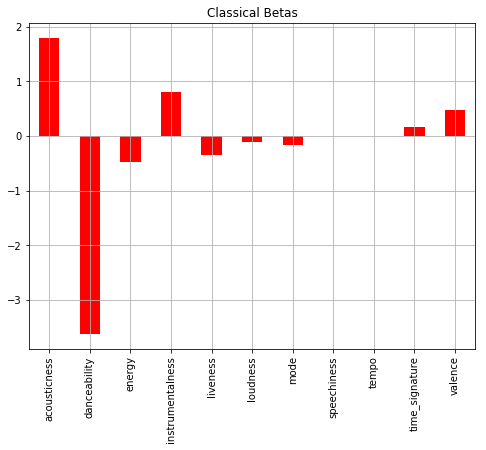

In [22]:
betas.loc['classical'].plot(kind='bar', color='red', title='Classical Betas',grid =True, figsize=(8,6));

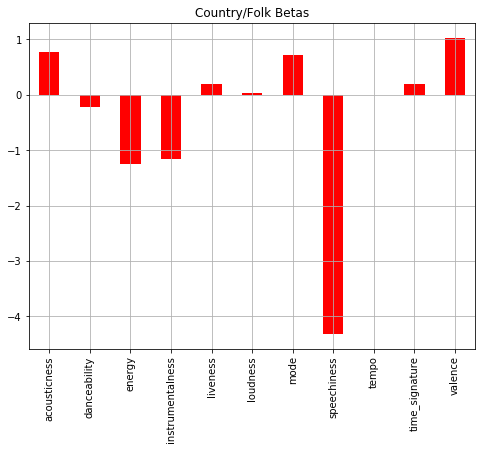

In [23]:
betas.loc['country, folk'].plot(kind='bar', color='red', title='Country/Folk Betas',grid =True, figsize=(8,6));

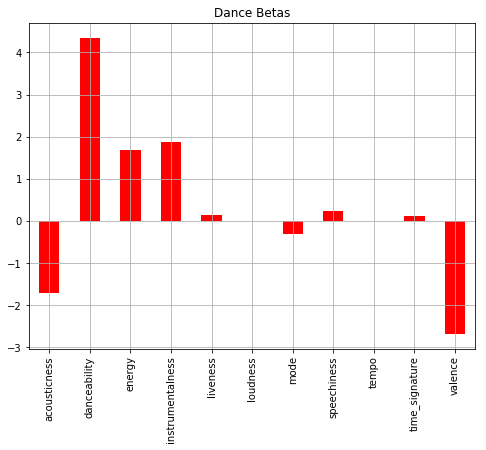

In [24]:
betas.loc['dance'].plot(kind='bar', color='red', title='Dance Betas',grid =True, figsize=(8,6));

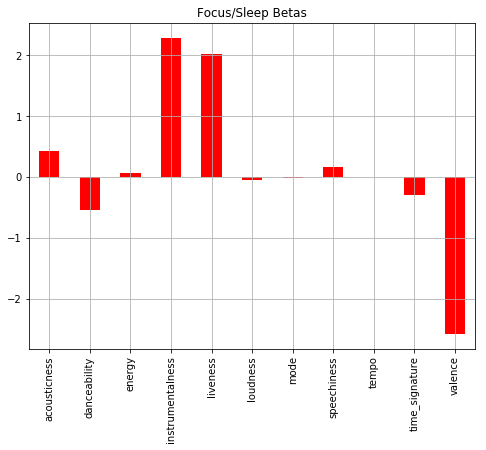

In [25]:
betas.loc['focus/sleep'].plot(kind='bar', color='red', title='Focus/Sleep Betas',grid =True, figsize=(8,6));

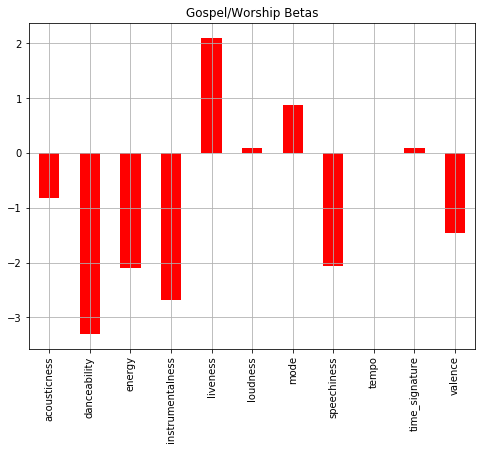

In [26]:
betas.loc['gospel/worship'].plot(kind='bar', color='red', title='Gospel/Worship Betas',grid =True, figsize=(8,6));

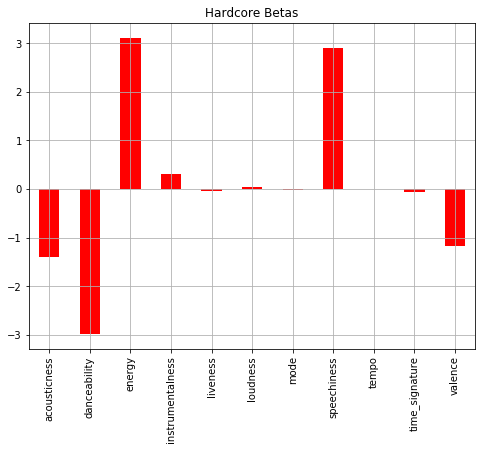

In [27]:
betas.loc['hardcore'].plot(kind='bar', color='red', title='Hardcore Betas',grid =True, figsize=(8,6));

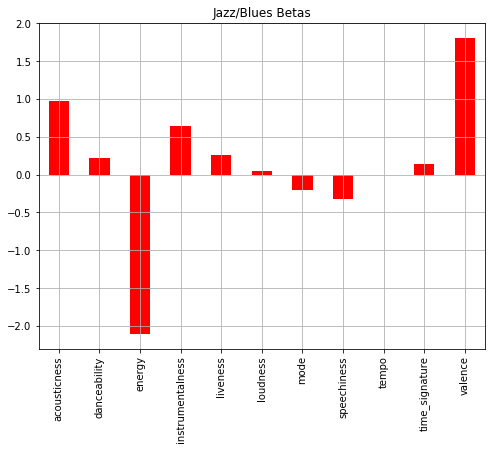

In [28]:
betas.loc['jazz/blues'].plot(kind='bar', color='red', title='Jazz/Blues Betas',grid =True, figsize=(8,6));

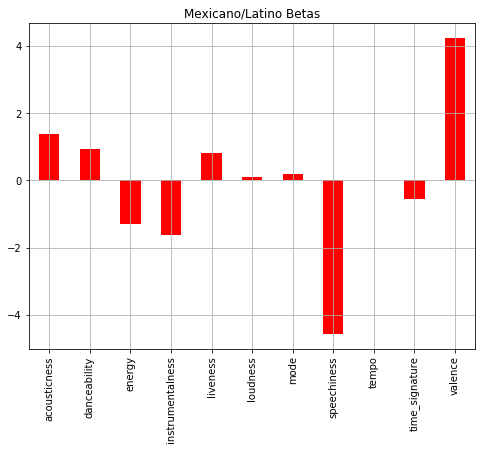

In [29]:
betas.loc['mexicano/latino'].plot(kind='bar', color='red', title='Mexicano/Latino Betas',grid =True, figsize=(8,6));

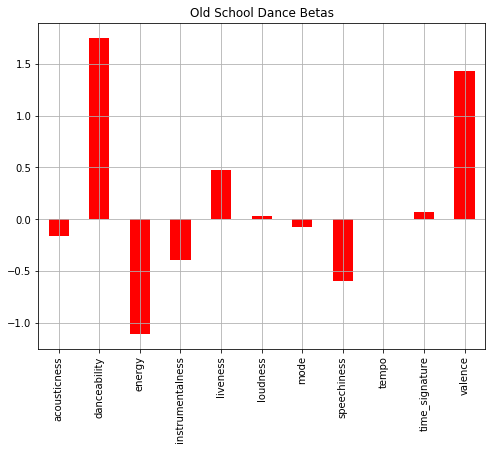

In [30]:
betas.loc['old school dance'].plot(kind='bar', color='red', title='Old School Dance Betas',grid =True, figsize=(8,6));

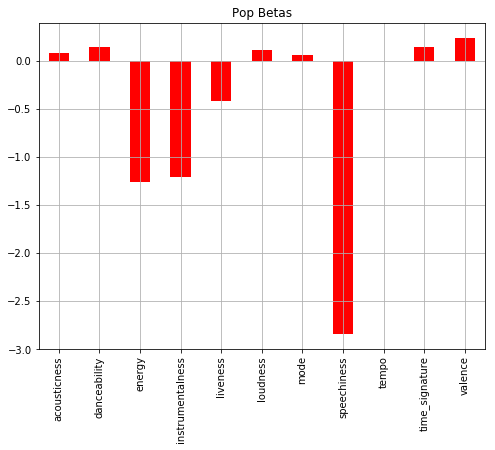

In [31]:
betas.loc['pop'].plot(kind='bar', color='red', title='Pop Betas',grid =True, figsize=(8,6));

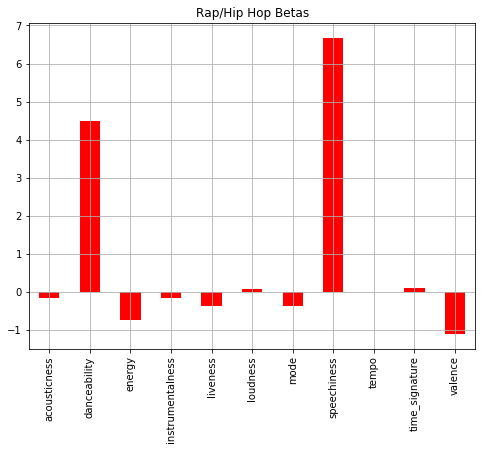

In [32]:
betas.loc['rap/hip hop'].plot(kind='bar', color='red', title='Rap/Hip Hop Betas',grid =True, figsize=(8,6));

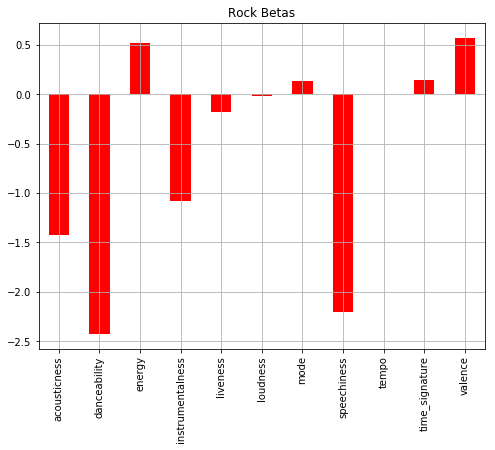

In [33]:
betas.loc['rock'].plot(kind='bar', color='red', title='Rock Betas',grid =True, figsize=(8,6));

# SGD Classifier
This model was used to try and speed the modeling process up computationally. This model can optimize over many loss functions and take many different penalties. The hyperprameter were tuned with Randomized Search Cross Validation. This model did score the worse out of all my models.

In [282]:
sgd = SGDClassifier(random_state=24)


In [283]:
sgd.fit(X_train, y_train)

/Users/scottsanowitz/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=24, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [36]:
sgd.score(X_val, y_val)

0.24026171637248936

In [46]:
pipe = Pipeline([
    ('sgd',SGDClassifier(random_state=24, tol=0) )
])

In [47]:
params = {
    'sgd__loss':['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron'],
    'sgd__penalty':['l1', 'l2', None,'elasticnet'],
    'sgd__alpha':np.arange(0,1,.0001)
    
}

In [48]:
rs = RandomizedSearchCV(pipe, param_distributions=params, scoring='accuracy', random_state=24)

In [49]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=24, shuffle=True,
       tol=0, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'sgd__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 'sgd__penalty': ['l1', 'l2', None, 'elasticnet'], 'sgd__alpha': array([0.000e+00, 1.000e-04, ..., 9.998e-01, 9.999e-01])},
          pre_dispatch='2*n_jobs', random_state=24, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [50]:
print('best_params:',rs.best_params_)
print('best score:',rs.best_score_)

best_params: {'sgd__penalty': 'l2', 'sgd__loss': 'log', 'sgd__alpha': 0.7635000000000001}
best score: 0.37983159176219944


# XGBoost
XGBoost is famous for winning many kaggle competitions. This model is very versatile, for classification we can use a tree method. The hyperparameters were optimized with Randomized Search Cross Validation. The model already has regularization built in to it to account for overffiting. This model was my second best model behind Random Forest. 

In [48]:
xgb = XGBClassifier(n_estimators=1_000, random_state=24,objective='multi:softmax', num_class=12)

In [49]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, num_class=12, objective='multi:softprob',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [50]:
xgb.score(X_val,y_val)

0.46226415094339623

In [51]:
xgb.score(X_test,y_test)

0.4638822321122903

In [68]:
pipe_xgb = Pipeline([
    ('xgb', XGBClassifier(n_estimators=100, random_state=24,objective='multi:softmax', num_class=12, n_jobs=12))
])

In [69]:
params={'xgb__reg_alpha':np.arange(0,1,.1),
        'xgb__reg_lambda': np.arange(0,1,.1),
        'xgb__max_depth':[3,4,5,6,7,8,9,10]}

In [70]:
rs = RandomizedSearchCV(pipe_xgb, param_distributions=params, random_state=24)

In [71]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=12, nthread=None, num_class=12, objective='multi:softmax',
       random_state=24, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'xgb__reg_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'xgb__reg_lambda': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'xgb__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs', random_state=24, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [72]:
rs.best_score_

0.46251394947752866

In [73]:
rs.best_params_

{'xgb__reg_lambda': 0.9, 'xgb__reg_alpha': 0.9, 'xgb__max_depth': 7}

In [74]:
xgb = XGBClassifier(n_estimators=1_000, random_state=24,objective='multi:softmax', num_class=12,
                   n_jobs=2, reg_alpha=.9, reg_lambda=.9, max_depth =7)

In [75]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=2, nthread=None, num_class=12, objective='multi:softprob',
       random_state=24, reg_alpha=0.9, reg_lambda=0.9, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [76]:
xgb.score(X_val, y_val)

0.46850273889227023

In [77]:
xgb.score(X_test, y_test)

0.474266803606071

In [79]:
s = sorted(list(zip(xgb.feature_importances_, X.columns )), reverse=True)

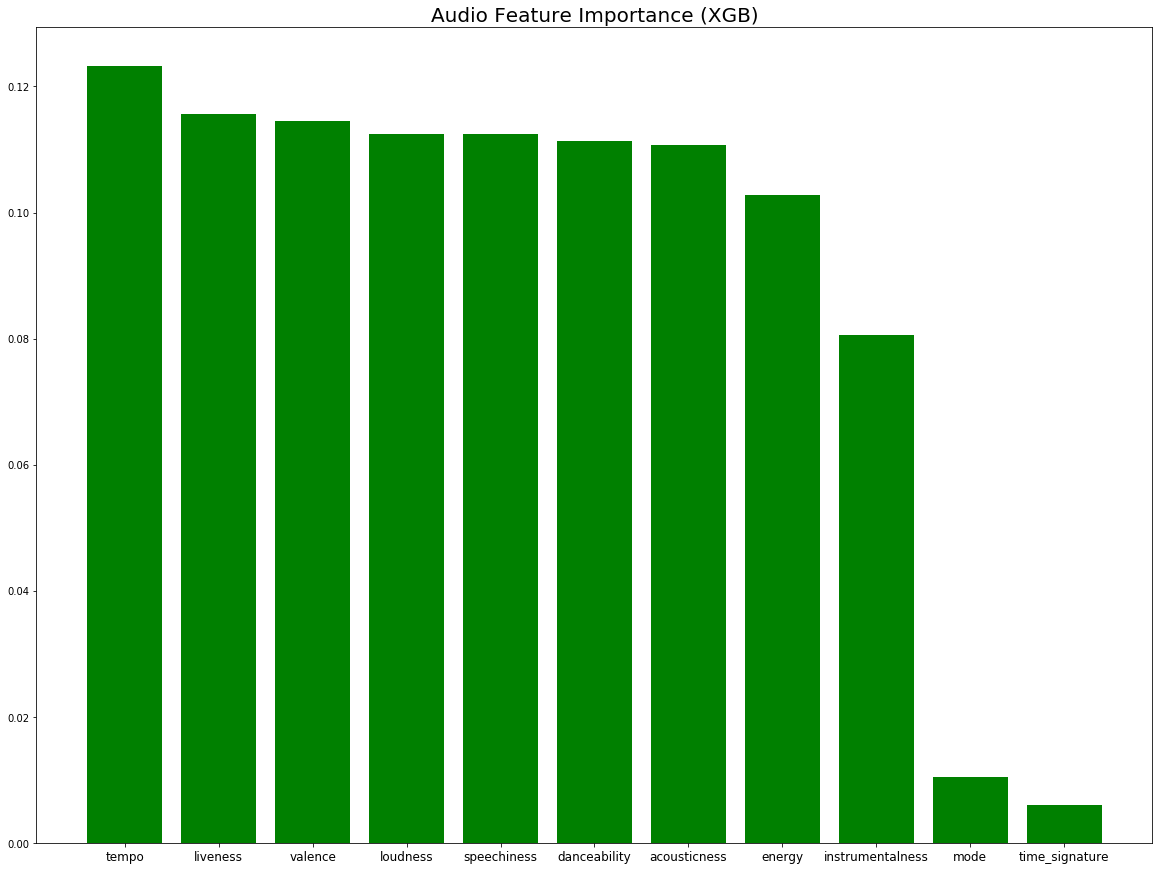

In [80]:
plt.figure(figsize=(20, 15))
plt.title('Audio Feature Importance (XGB)', fontsize=20)
sy = [y[0] for y in s]
sx = [x[1] for x in s]
plt.bar(sx, sy, color ='g')
plt.xticks(fontsize=12)
plt.tight_layout
plt.show()

# One vs Rest
A model which creates a binary output for each class using an estimator of one's choice. For this model I used Logistic Regression again, but this time it runs 12 Logistic Regression, one for each class(target). While this model did not score well like Logistic Regression, it produced nice visuals of confidense and probabilty densities.

In [15]:
ovr = OneVsRestClassifier(LogisticRegression(penalty='l1',random_state=24))

In [16]:
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=24, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [17]:
ovr.score(X_val, y_val)

0.4280279975654291

In [18]:
ovr.score(X_test, y_test)

0.43113089124728976

In [19]:
#Data Frame of confidence
confidence = pd.DataFrame(ovr.decision_function(X_val), columns=np.unique(le.inverse_transform(y)))

/Users/scottsanowitz/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
confidence = confidence.T

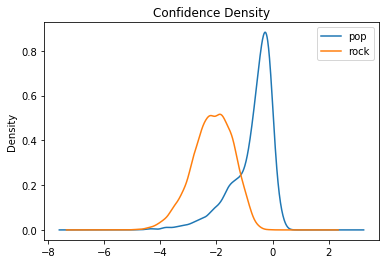

In [21]:
# kernel density plot of confidence
plt.title("Confidence Density")
confidence.loc['pop'].plot.kde(label='pop')
confidence.loc['rock'].plot.kde(label='rock')
plt.legend();

In [22]:
#Data frame of probabilities
proba = pd.DataFrame(ovr.predict_proba(X_val), columns=np.unique(le.inverse_transform(y)))

/Users/scottsanowitz/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
proba = proba.T

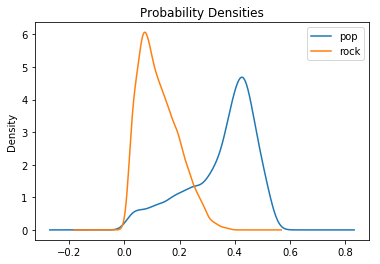

In [24]:
#kernel density plot of probabilities
plt.title("Probability Densities")
proba.loc['pop'].plot.kde(label='pop')
proba.loc['rock'].plot.kde(label='rock')
plt.legend();

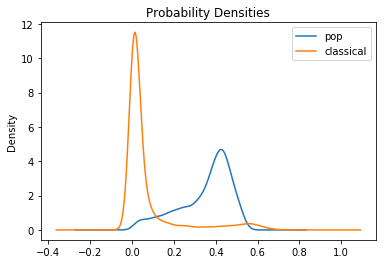

In [25]:
plt.title("Probability Densities")
proba.loc['pop'].plot.kde(label='pop')
proba.loc['classical'].plot.kde(label='classical')
plt.legend();

# Neural Net

In an attempt to see if I could really make my model any better with the features currently set up the way they are I used a neural network. The neural network had 3 hidden layers and an output layer with softmax for multiclassification. The key here was utilizing early stopping, which out of 100 set epochs stopped after usually around 10 epochs, meaning my model could not produce a better score on my validation data. This show my model could not be improved much beyong these scores without a different approach or different features.

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda 
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import backend as K


Using TensorFlow backend.


In [75]:
import tensorflow as tf
tf.__version__

'1.8.0'

In [76]:
#scale the data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [77]:
#make target into matrix for neural net
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [78]:
print(X_train.shape)
print(y_train.shape)

(19714, 11)
(19714, 12)


In [79]:
#model type
model = Sequential()
# input layer and output layer
n_input = X_train.shape[1]
n_output = y_train.shape[1]
#input,3 hidden with relu activation, out put with softmax activation
model.add(Dense(n_input, input_dim=n_input, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(n_output, activation = 'softmax'))


In [80]:
#compile with earlystopping
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=0)

In [81]:
#fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                      epochs=100, batch_size=75,
                     callbacks=[early_stop])

Train on 19714 samples, validate on 8763 samples
Epoch 1/100
19714/19714 [==============================] - 1s 38us/step - loss: 2.0921 - acc: 0.3628 - val_loss: 1.9036 - val_acc: 0.4037
Epoch 2/100
19714/19714 [==============================] - 0s 20us/step - loss: 1.8590 - acc: 0.4085 - val_loss: 1.8147 - val_acc: 0.4173
Epoch 3/100
19714/19714 [==============================] - 0s 22us/step - loss: 1.7905 - acc: 0.4158 - val_loss: 1.7627 - val_acc: 0.4187
Epoch 4/100
19714/19714 [==============================] - 0s 22us/step - loss: 1.7554 - acc: 0.4210 - val_loss: 1.7398 - val_acc: 0.4215
Epoch 5/100
19714/19714 [==============================] - 0s 21us/step - loss: 1.7367 - acc: 0.4214 - val_loss: 1.7249 - val_acc: 0.4236
Epoch 6/100
19714/19714 [==============================] - 0s 20us/step - loss: 1.7250 - acc: 0.4232 - val_loss: 1.7188 - val_acc: 0.4260
Epoch 7/100
19714/19714 [==============================] - 0s 21us/step - loss: 1.7176 - acc: 0.4239 - val_loss: 1.7103 - v

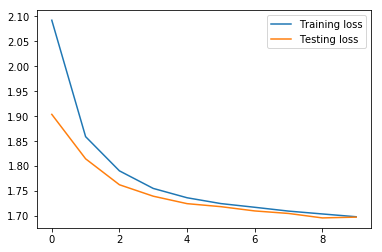

In [83]:
#plot of training loss vs. testing loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend();

# Random Forest with NLP  added to models via song titles
Though against the spirit of the project to use pure sound data, I tried some NLP by vectorizing the words in the song titles using CountVectorizer. It gave me a very simialr score to the random forest without NLP. This took a very long time to fit and was not computationally worth the time for a similar score.

In [84]:
df.head()

,acousticness,artist_name,artist_uri,danceability,energy,genre,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,track_id,track_name,valence,target
0,0.5710,1:43,spotify:artist:39EHxSQAIaWusRqSI9xoyF,0.641,0.665,"['classic opm', 'opm']",0.001070,11,0.159,-7.839,1,41,0.0263,138.017,4,1vPk6ZTflnvm8LgtXzPDrT,Sa Isang Sulyap Mo,0.677,old school dance
1,0.1220,2 AM,spotify:artist:17lzZA2AlOHwCwFALHttmp,0.796,0.513,"['alternative emo', 'emo', 'modern rock']",0.000000,11,0.150,-7.140,0,74,0.4520,75.018,4,1nX9KhK3Fff27SnrIor2Yb,4 AM,0.235,rock
2,0.2290,2:54,spotify:artist:3TUmwNx3l8S2nCoGKqIhjA,0.792,0.256,['metropopolis'],0.548000,11,0.350,-12.525,1,52,0.1910,87.774,4,44L7aDHaRzb9pMWEZjSH8u,Train to Skaville,0.563,pop
3,0.0375,2,spotify:artist:66CXWjxzNUsdJxJ2JdwvnR,0.703,0.696,"['hip hop', 'pop', 'pop rap', 'rap', 'southern...",0.000006,11,0.274,-5.482,1,98,0.0529,121.969,4,5SxkdsY1ufZzoq9iXceLw9,no tears left to cry,0.366,pop
4,0.8830,3,spotify:artist:15UsOTVnJzReFVN1VCnxy4,0.610,0.258,"['alternative metal', 'canadian metal', 'canad...",0.014500,11,0.103,-12.758,1,81,0.0331,127.080,4,2oe6dDthgthqUkfL3czpEd,"ALONE, PART 3",0.164,pop


In [85]:
#countvectorize
cvec = CountVectorizer(stop_words='english')
tracks = cvec.fit_transform(df['track_name'])

In [86]:
# A dataframe of word vectors with their correspsonding word as a column
tracks= pd.DataFrame(tracks.toarray(), columns=cvec.get_feature_names(), index = df.index)

In [87]:
tracks.head()

,000,01,02,028,0330,06,07,0ne,10,100,...,웃으며,위글위글,이별의,저지른,정인,종이,중독,촉이,해줘요,헤어지지
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
#original features
X = df[['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]
       

In [89]:
#NLP features concanated with original features
X = pd.concat([X, tracks], axis=1)

In [90]:
#make target
y = df['target']

In [91]:
#lable encode target
le = LabelEncoder()
y = le.fit_transform(y)

In [92]:
#split for train test
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=24)

In [93]:
#split for train val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=24)

In [94]:
X_train.shape

(19714, 23788)

In [96]:
rf = RandomForestClassifier(n_estimators=200, max_features='sqrt')

In [97]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [98]:
rf.score(X_val, y_val)

0.4910225197808886

In [99]:
rf.score(X_test, y_test)

0.494921830423371

In [100]:
s = sorted(list(zip( rf.feature_importances_, X.columns)),reverse=True)[:11]

In [101]:
s

[(0.046893695272811176, 'acousticness'),
 (0.04579125505137716, 'loudness'),
 (0.04528207130671842, 'danceability'),
 (0.04454875277318285, 'energy'),
 (0.04358762565350545, 'speechiness'),
 (0.0430463434719716, 'instrumentalness'),
 (0.042814339374798116, 'valence'),
 (0.03803733207774221, 'tempo'),
 (0.03581401090733192, 'liveness'),
 (0.00697392701884975, 'mode'),
 (0.0067937136827878955, 'time_signature')]

In [102]:
y_hat_nlp = rf.predict(X_test)

In [103]:
print(classification_report(y_test, y_hat_nlp, target_names=target_names))

                  precision    recall  f1-score   support

       classical       0.71      0.71      0.71       666
    country/folk       0.61      0.06      0.10       384
           dance       0.63      0.42      0.50       924
     focus/sleep       0.67      0.46      0.55       231
  gospel/worship       0.66      0.14      0.23       136
        hardcore       0.51      0.21      0.30       375
      jazz/blues       0.53      0.18      0.26       648
 mexicano/latino       0.72      0.26      0.38       359
old school dance       0.62      0.07      0.12       231
             pop       0.44      0.88      0.59      3050
     rap/hip hop       0.54      0.28      0.37       682
            rock       0.49      0.14      0.21      1077

     avg / total       0.54      0.49      0.44      8763



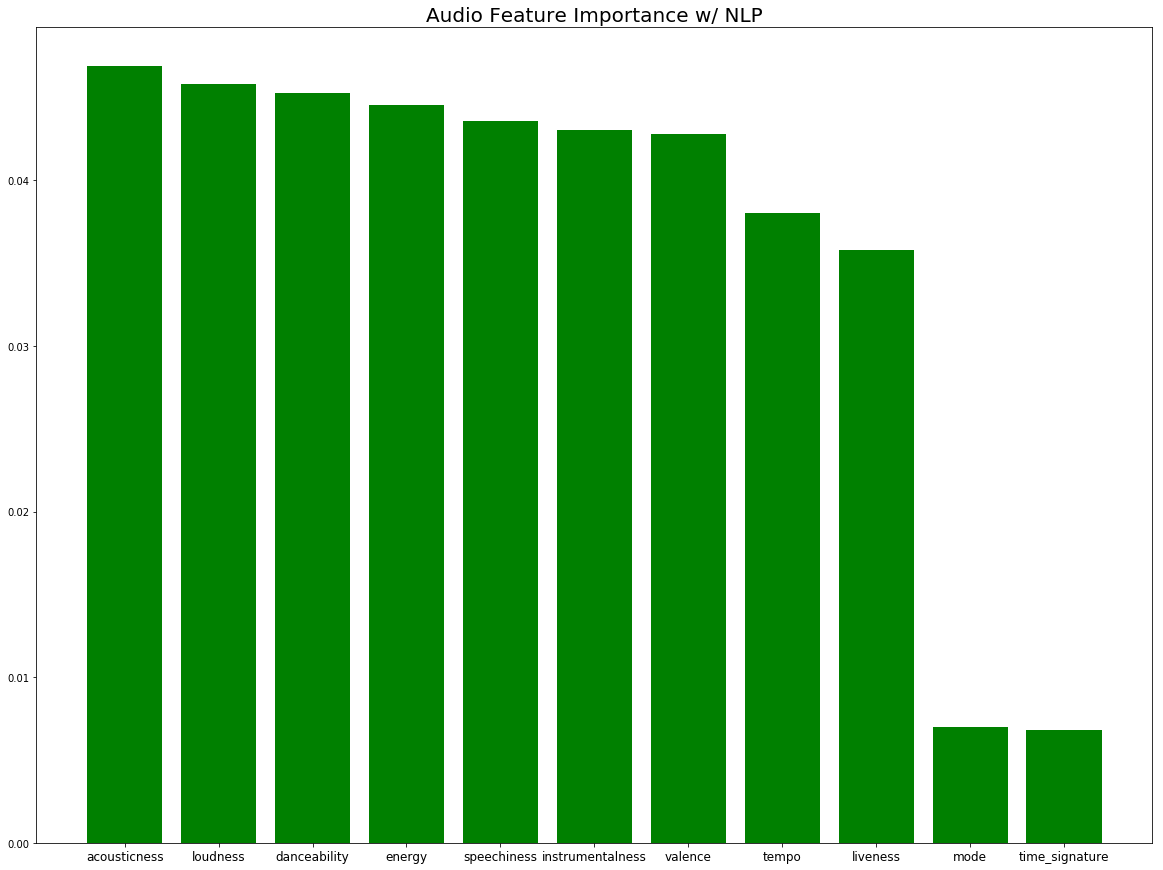

In [104]:
plt.figure(figsize=(20, 15))
plt.title('Audio Feature Importance w/ NLP', fontsize=20)
sy = [y[0] for y in s]
sx = [x[1] for x in s]
plt.bar(sx, sy, color ='g')
plt.xticks(fontsize=12)
plt.tight_layout
plt.show()

# Clustering Audio Features
Since none of my models could produce an accuracy of above 50%, I invedstigated how a cluster method known as k-means would split the data into 12 clusters. The clusters were treated as targets and predicted on using various Random Forest models with different features. Tempo and Loudness proved to be a point of interest as they were the only features not on a 0 to 1 scale. The clustering algorithm would basically split the clusters on different tmepo and loudness ranges as seen below. Each cluster was given extensive exploratory data analysis as to learn what features were featured in a particluar  cluster. Finally the original binning target genres distributions in each cluster are shown as a cross reference of human intuition to the machine model.

In [20]:
#import k-mean cluster
from sklearn.cluster import KMeans

In [49]:
df.head(5)

,acousticness,artist_name,artist_uri,danceability,energy,genre,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,track_id,track_name,valence,target,predicted
0,0.5710,1:43,spotify:artist:39EHxSQAIaWusRqSI9xoyF,0.641,0.665,"['classic opm', 'opm']",0.001070,11,0.159,-7.839,1,41,0.0263,138.017,4,1vPk6ZTflnvm8LgtXzPDrT,Sa Isang Sulyap Mo,0.677,old school dance,10
1,0.1220,2 AM,spotify:artist:17lzZA2AlOHwCwFALHttmp,0.796,0.513,"['alternative emo', 'emo', 'modern rock']",0.000000,11,0.150,-7.140,0,74,0.4520,75.018,4,1nX9KhK3Fff27SnrIor2Yb,4 AM,0.235,rock,0
2,0.2290,2:54,spotify:artist:3TUmwNx3l8S2nCoGKqIhjA,0.792,0.256,['metropopolis'],0.548000,11,0.350,-12.525,1,52,0.1910,87.774,4,44L7aDHaRzb9pMWEZjSH8u,Train to Skaville,0.563,pop,4
3,0.0375,2,spotify:artist:66CXWjxzNUsdJxJ2JdwvnR,0.703,0.696,"['hip hop', 'pop', 'pop rap', 'rap', 'southern...",0.000006,11,0.274,-5.482,1,98,0.0529,121.969,4,5SxkdsY1ufZzoq9iXceLw9,no tears left to cry,0.366,pop,0
4,0.8830,3,spotify:artist:15UsOTVnJzReFVN1VCnxy4,0.610,0.258,"['alternative metal', 'canadian metal', 'canad...",0.014500,11,0.103,-12.758,1,81,0.0331,127.080,4,2oe6dDthgthqUkfL3czpEd,"ALONE, PART 3",0.164,pop,9


In [50]:
#features
X = df[['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

In [51]:
km = KMeans(n_clusters=12, random_state=24) #  12 clusters, same number as binning made

In [52]:
#fit the model
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=24, tol=0.0001, verbose=0)

In [53]:
#distribution of data into clusters
pd.Series(km.labels_).value_counts()

5     6697
1     5646
8     4934
11    4482
9     3757
0     2770
10    2662
4     1173
2     1121
7     1010
3      729
6       68
dtype: int64

In [54]:
6697/len(X) #new baseline

0.19107535165054637

In [55]:
#make a new target using the clusters
df['predicted'] = km.labels_

In [56]:
df['predicted'][0:5]

0    11
1     9
2     9
3     5
4     5
Name: predicted, dtype: int32

In [57]:
#set target
y = df['predicted']

In [58]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)

In [59]:
#split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=24)

In [60]:
rf = RandomForestClassifier(n_estimators = 100,max_features='sqrt', random_state=24)

In [61]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

In [62]:
rf.score(X_val, y_val)

0.9831101643335363

In [63]:
rf.score(X_test, y_test)

0.9799155540340067

In [64]:
cross_val_score(rf, X_test, y_test, scoring='accuracy')

array([0.96580027, 0.97330595, 0.97223174])

In [65]:
y_hat_cluster = rf.predict(X_test)

In [66]:
print(classification_report(y_test, y_hat_cluster, target_names=['0','1','2','3','4','5','6','7','8','9','10','11']))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       693
          1       0.98      0.98      0.98      1412
          2       0.94      0.91      0.93       280
          3       1.00      0.90      0.95       182
          4       0.96      0.95      0.95       293
          5       0.99      0.99      0.99      1674
          6       1.00      1.00      1.00        17
          7       0.90      0.92      0.91       252
          8       0.99      0.98      0.99      1234
          9       0.97      0.98      0.97       939
         10       0.97      1.00      0.99       666
         11       0.99      0.99      0.99      1121

avg / total       0.98      0.98      0.98      8763



In [67]:
s = sorted(list(zip( rf.feature_importances_, X.columns)),reverse=True)

One can see tempo is almost a 1 in feature importance, leading a further inverstigtion into these tempo clusters

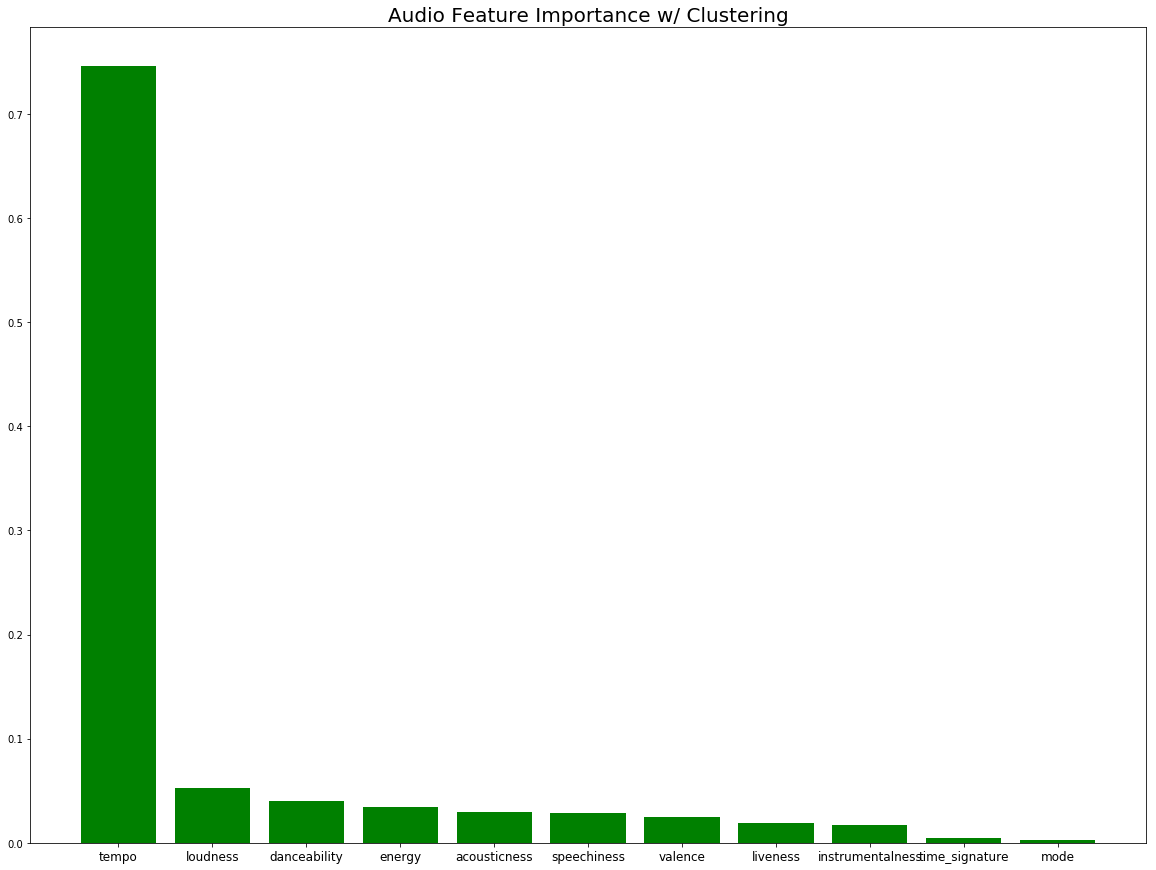

In [68]:
plt.figure(figsize=(20, 15))
plt.title('Audio Feature Importance w/ Clustering', fontsize=20)
sy = [y[0] for y in s]
sx = [x[1] for x in s]
plt.bar(sx, sy, color ='g')
plt.xticks(fontsize=12)
plt.tight_layout
plt.show()

In [69]:
tempo_cluster =([(df[df['predicted'] == 0]['tempo'].min(),df[df['predicted'] == 0]['tempo'].max()),
 (df[df['predicted'] == 1]['tempo'].min(), df[df['predicted'] == 1]['tempo'].max()),
 (df[df['predicted'] == 2]['tempo'].min(), df[df['predicted'] == 2]['tempo'].max()),
 (df[df['predicted'] == 3]['tempo'].min(), df[df['predicted'] == 3]['tempo'].max()),
 (df[df['predicted'] == 4]['tempo'].min(), df[df['predicted'] == 4]['tempo'].max()),
 (df[df['predicted'] == 5]['tempo'].min(), df[df['predicted'] == 5]['tempo'].max()),
 (df[df['predicted'] == 6]['tempo'].min(), df[df['predicted'] == 6]['tempo'].max()),
 (df[df['predicted'] == 7]['tempo'].min(), df[df['predicted'] == 7]['tempo'].max()),
 (df[df['predicted'] == 8]['tempo'].min(), df[df['predicted'] == 8]['tempo'].max()),
 (df[df['predicted'] == 9]['tempo'].min(), df[df['predicted'] == 9]['tempo'].max()),
 (df[df['predicted'] == 10]['tempo'].min(), df[df['predicted'] == 10]['tempo'].max()),
 (df[df['predicted'] == 11]['tempo'].min(), df[df['predicted'] == 11]['tempo'].max())])

In [70]:
print(tempo_cluster)

[(146.496, 163.168), (87.838, 103.492), (79.36399999999998, 110.145), (183.641, 232.12400000000002), (35.946999999999996, 79.63600000000002), (116.887, 131.81799999999998), (0.0, 0.0), (110.272, 147.871), (102.39299999999999, 118.01299999999999), (64.01899999999999, 88.554), (162.671, 183.706), (131.717, 146.656)]


In [71]:
tempo_count = [(df['tempo'].between(tempo_cluster[0][0],tempo_cluster[0][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[1][0],tempo_cluster[1][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[2][0],tempo_cluster[2][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[3][0],tempo_cluster[3][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[4][0],tempo_cluster[4][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[5][0],tempo_cluster[5][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[6][0],tempo_cluster[6][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[7][0],tempo_cluster[7][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[8][0],tempo_cluster[8][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[9][0],tempo_cluster[9][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[10][0],tempo_cluster[10][1], inclusive=True)).sum(),
               (df['tempo'].between(tempo_cluster[11][0],tempo_cluster[11][1], inclusive=True)).sum()]


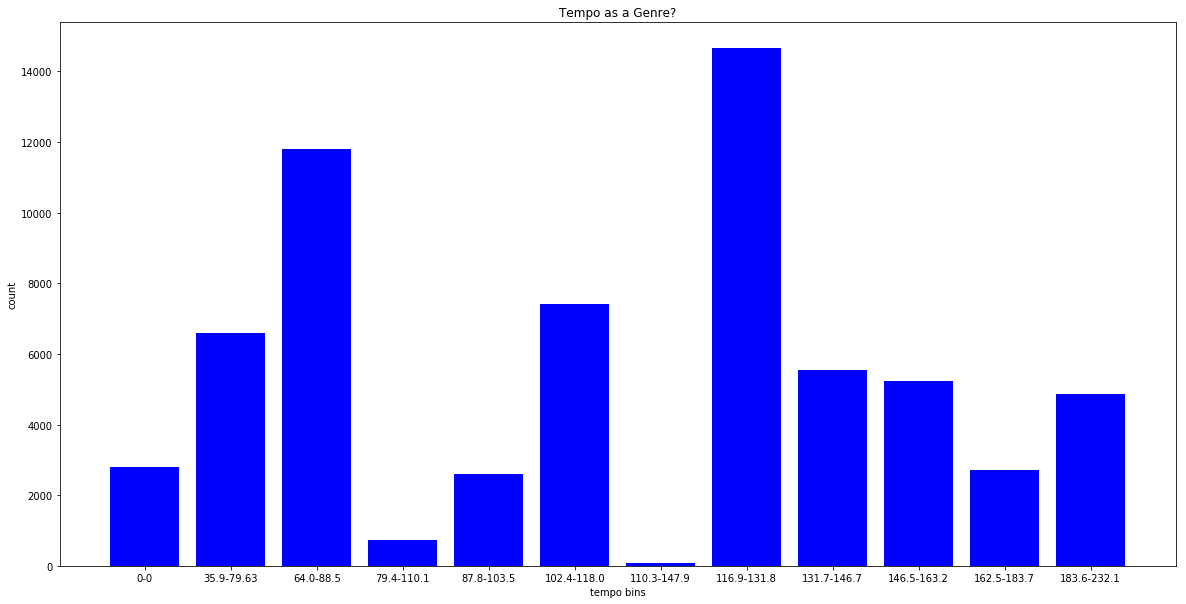

In [73]:
x = ['0-0', '35.9-79.63', '64.0-88.5', '79.4-110.1','87.8-103.5','102.4-118.0','110.3-147.9','116.9-131.8','131.7-146.7',
'146.5-163.2','162.5-183.7','183.6-232.1']
plt.figure(figsize=(20,10))
plt.bar(x, tempo_count, color = 'blue')
plt.xlabel('tempo bins')
plt.ylabel('count')
plt.title('Tempo as a Genre?')
plt.show();

### Distribution of target genres in tempo clusters
Of note the only genre that leads in distribution that is not pop is classical

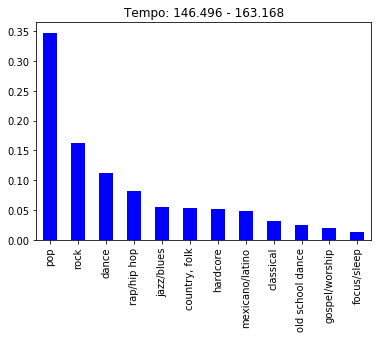

In [148]:
df[df.predicted == 0]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 146.496 - 163.168', color ='blue');

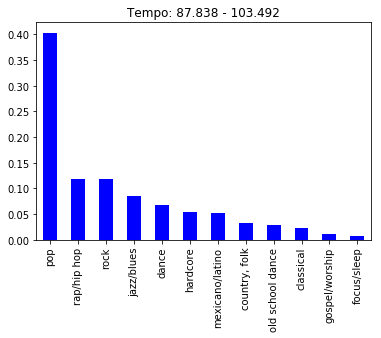

In [149]:
df[df.predicted == 1]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 87.838 - 103.492', color='blue');

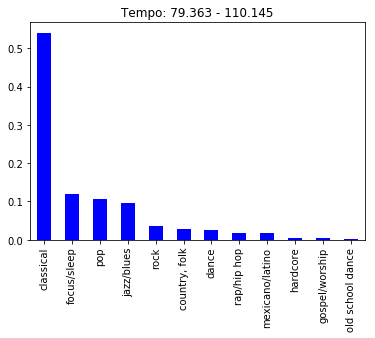

In [150]:
df[df.predicted == 2]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 79.363 - 110.145', color='blue');

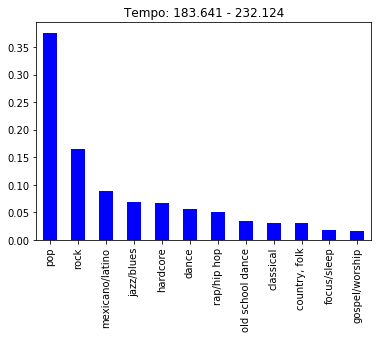

In [151]:
df[df.predicted == 3]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 183.641 - 232.124', color='blue');

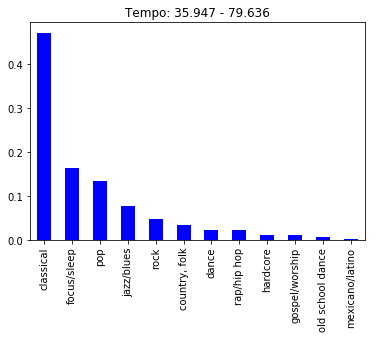

In [152]:
df[df.predicted == 4]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 35.947 - 79.636', color='blue');

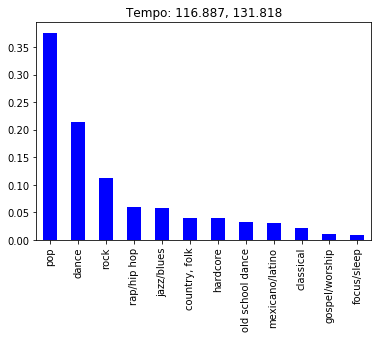

In [153]:
df[df.predicted == 5]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 116.887, 131.818', color='blue');

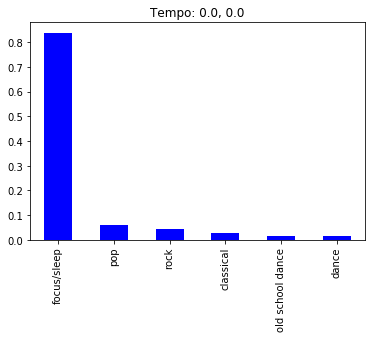

In [154]:
df[df.predicted == 6]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 0.0, 0.0', color='blue');

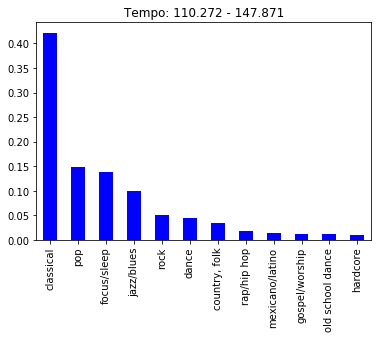

In [156]:
df[df.predicted == 7]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 110.272 - 147.871', color='blue');

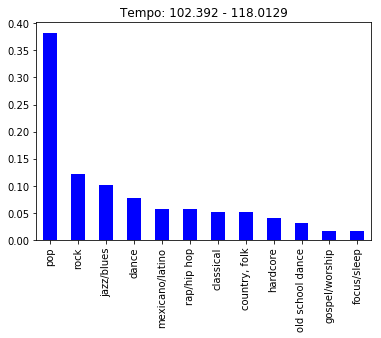

In [157]:
df[df.predicted == 8]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 102.392 - 118.0129', color='blue');

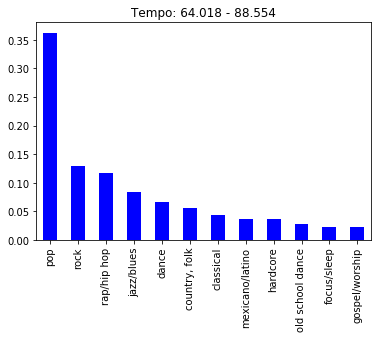

In [158]:
df[df.predicted == 9]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 64.018 - 88.554', color='blue');

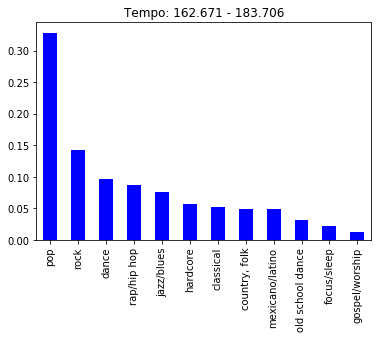

In [159]:
df[df.predicted == 10]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 162.671 - 183.706', color='blue');

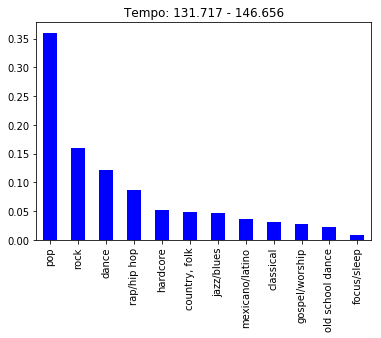

In [160]:
df[df.predicted == 11]['target'].value_counts(normalize=True).plot(kind='bar', title= 'Tempo: 131.717 - 146.656', color='blue');

# Remove Tempo and Cluster
With tempo removed the feature importance of loudness went close to 1, so k-mean clustered made  clusters based on loudness ranges.

In [6]:
df.head(5)

,acousticness,artist_name,artist_uri,danceability,energy,genre,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,track_id,track_name,valence,target
0,0.5710,1:43,spotify:artist:39EHxSQAIaWusRqSI9xoyF,0.641,0.665,"['classic opm', 'opm']",0.001070,11,0.159,-7.839,1,41,0.0263,138.017,4,1vPk6ZTflnvm8LgtXzPDrT,Sa Isang Sulyap Mo,0.677,old school dance
1,0.1220,2 AM,spotify:artist:17lzZA2AlOHwCwFALHttmp,0.796,0.513,"['alternative emo', 'emo', 'modern rock']",0.000000,11,0.150,-7.140,0,74,0.4520,75.018,4,1nX9KhK3Fff27SnrIor2Yb,4 AM,0.235,rock
2,0.2290,2:54,spotify:artist:3TUmwNx3l8S2nCoGKqIhjA,0.792,0.256,['metropopolis'],0.548000,11,0.350,-12.525,1,52,0.1910,87.774,4,44L7aDHaRzb9pMWEZjSH8u,Train to Skaville,0.563,pop
3,0.0375,2,spotify:artist:66CXWjxzNUsdJxJ2JdwvnR,0.703,0.696,"['hip hop', 'pop', 'pop rap', 'rap', 'southern...",0.000006,11,0.274,-5.482,1,98,0.0529,121.969,4,5SxkdsY1ufZzoq9iXceLw9,no tears left to cry,0.366,pop
4,0.8830,3,spotify:artist:15UsOTVnJzReFVN1VCnxy4,0.610,0.258,"['alternative metal', 'canadian metal', 'canad...",0.014500,11,0.103,-12.758,1,81,0.0331,127.080,4,2oe6dDthgthqUkfL3czpEd,"ALONE, PART 3",0.164,pop


In [7]:
X = df[['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness','time_signature', 'valence']]

In [8]:
km = KMeans(n_clusters=12, random_state=24)

In [9]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=24, tol=0.0001, verbose=0)

In [10]:
pd.Series(km.labels_).value_counts()

0     7486
7     6827
5     5331
4     4109
2     3750
8     2762
3     1669
10    1221
1      885
6      599
9      326
11      84
dtype: int64

In [11]:
df['predicted'] = km.labels_

In [12]:
y = df['predicted']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=24)

In [15]:
rf = RandomForestClassifier(n_estimators = 100,max_features='sqrt', random_state=24)

In [16]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

In [17]:
rf.score(X_val, y_val)

0.9945222154595252

In [18]:
rf.score(X_test, y_test)

0.9942941914869337

In [19]:
y_hat_no_tempo = rf.predict(X_test)

In [20]:
print(classification_report(y_test, y_hat_no_tempo, target_names=['0','1','2','3','4','5','6','7','8','9','10','11']))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1872
          1       1.00      0.98      0.99       221
          2       0.99      0.99      0.99       938
          3       0.99      0.99      0.99       417
          4       1.00      1.00      1.00      1027
          5       1.00      0.99      1.00      1333
          6       0.96      0.99      0.98       150
          7       1.00      1.00      1.00      1707
          8       0.99      1.00      0.99       691
          9       0.96      0.96      0.96        81
         10       0.98      0.99      0.99       305
         11       1.00      0.71      0.83        21

avg / total       0.99      0.99      0.99      8763



In [136]:
s = sorted(list(zip( rf.feature_importances_, X.columns)),reverse=True)

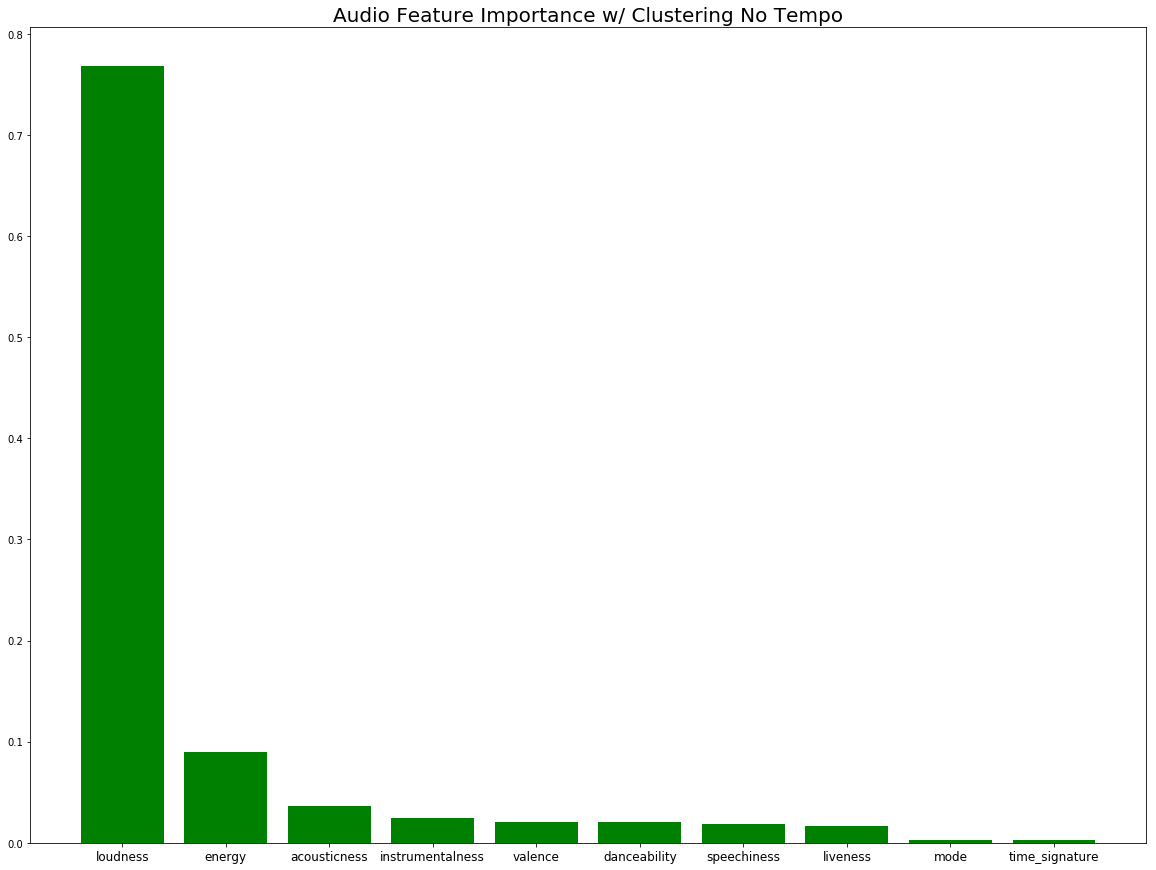

In [137]:
plt.figure(figsize=(20, 15))
plt.title('Audio Feature Importance w/ Clustering No Tempo', fontsize=20)
sy = [y[0] for y in s]
sx = [x[1] for x in s]
plt.bar(sx, sy, color ='g')
plt.xticks(fontsize=12)
plt.tight_layout
plt.show()

# No loudness, mode, time_signature
Without tempo and loudness all the features are on a 0 to 1 scale. This led to the most intriguing results. With the leading feature importance of valence at close to 0.25 there was no clear cut way the k-means clustered the data. This led to exploratory data analysis on each cluster. The top four feature importance's distribution are shown for each cluster via histograms of valence, acousticeness, instrumentalness and energy. Finally the cluster are cross referenced with the 12 target genres form the binning function.

In [21]:
#Everything on same scale between 0 to 1
df.head(5)

,acousticness,artist_name,artist_uri,danceability,energy,genre,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,track_id,track_name,valence,target
0,0.5710,1:43,spotify:artist:39EHxSQAIaWusRqSI9xoyF,0.641,0.665,"['classic opm', 'opm']",0.001070,11,0.159,-7.839,1,41,0.0263,138.017,4,1vPk6ZTflnvm8LgtXzPDrT,Sa Isang Sulyap Mo,0.677,old school dance
1,0.1220,2 AM,spotify:artist:17lzZA2AlOHwCwFALHttmp,0.796,0.513,"['alternative emo', 'emo', 'modern rock']",0.000000,11,0.150,-7.140,0,74,0.4520,75.018,4,1nX9KhK3Fff27SnrIor2Yb,4 AM,0.235,rock
2,0.2290,2:54,spotify:artist:3TUmwNx3l8S2nCoGKqIhjA,0.792,0.256,['metropopolis'],0.548000,11,0.350,-12.525,1,52,0.1910,87.774,4,44L7aDHaRzb9pMWEZjSH8u,Train to Skaville,0.563,pop
3,0.0375,2,spotify:artist:66CXWjxzNUsdJxJ2JdwvnR,0.703,0.696,"['hip hop', 'pop', 'pop rap', 'rap', 'southern...",0.000006,11,0.274,-5.482,1,98,0.0529,121.969,4,5SxkdsY1ufZzoq9iXceLw9,no tears left to cry,0.366,pop
4,0.8830,3,spotify:artist:15UsOTVnJzReFVN1VCnxy4,0.610,0.258,"['alternative metal', 'canadian metal', 'canad...",0.014500,11,0.103,-12.758,1,81,0.0331,127.080,4,2oe6dDthgthqUkfL3czpEd,"ALONE, PART 3",0.164,pop


In [22]:
X = df[['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'speechiness', 'valence']]


In [23]:
km = KMeans(n_clusters=12, random_state=24)

In [24]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=24, tol=0.0001, verbose=0)

In [25]:
pd.Series(km.labels_).value_counts()

11    5902
2     4824
0     4106
5     3226
10    3181
1     3164
9     2562
3     2444
6     1773
4     1418
7     1351
8     1098
dtype: int64

In [26]:
df['predicted'] = km.labels_

In [27]:
5902/len(X)

0.16839282147850151

In [28]:
y = df['predicted']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=24)

In [31]:
rf = RandomForestClassifier(n_estimators = 100,max_features='sqrt', random_state=24)

In [32]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

In [33]:
rf.score(X_val, y_val)

0.9613511868533171

In [34]:
rf.score(X_test, y_test)

0.9591464110464453

In [35]:
y_hat_zero_to_one = rf.predict(X_test)

In [36]:
print(classification_report(y_test, y_hat_zero_to_one, target_names=['0','1','2','3','4','5','6','7','8','9','10','11']))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93      1027
          1       0.95      0.94      0.95       791
          2       0.96      0.96      0.96      1206
          3       0.98      0.99      0.99       611
          4       0.97      0.96      0.97       354
          5       0.94      0.94      0.94       807
          6       0.98      0.97      0.98       443
          7       0.96      0.94      0.95       338
          8       0.95      0.95      0.95       274
          9       0.97      0.98      0.97       641
         10       0.95      0.97      0.96       795
         11       0.97      0.97      0.97      1476

avg / total       0.96      0.96      0.96      8763



In [37]:
s = sorted(list(zip( rf.feature_importances_, X.columns)),reverse=True)

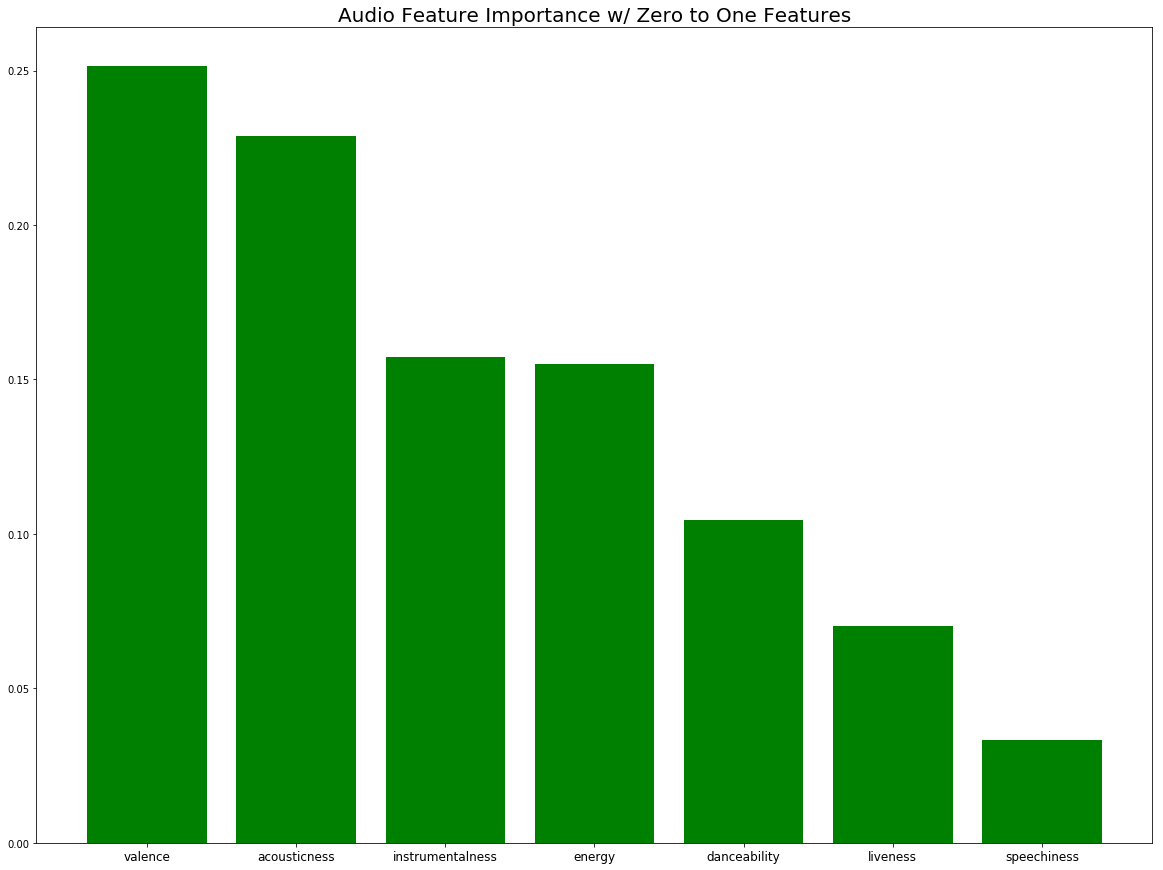

In [38]:
plt.figure(figsize=(20, 15))
plt.title('Audio Feature Importance w/ Zero to One Features', fontsize=20)
sy = [y[0] for y in s]
sx = [x[1] for x in s]
plt.bar(sx, sy, color ='g')
plt.xticks(fontsize=12)
plt.tight_layout
plt.show()

### Histograms of Valence, Acousticness, Instrumentalness, Energy

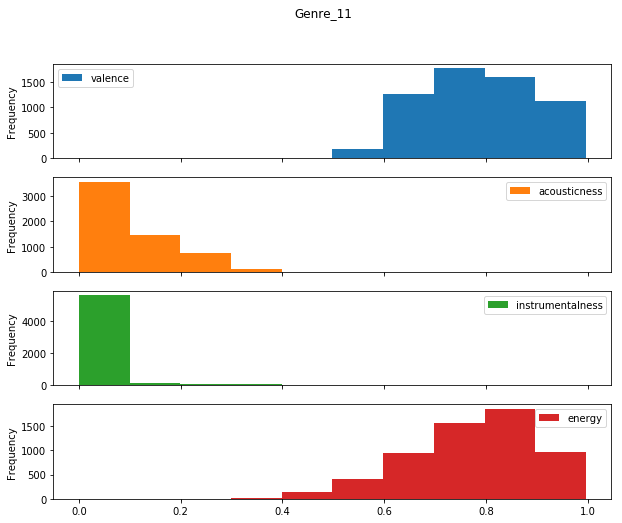

In [102]:
# four histograms of  valence, acousticmess, instrumentalness and energy, cluster 11
df[df['predicted'] == 11][['valence','acousticness','instrumentalness', 'energy']].plot(kind='hist', subplots=True, title='Genre_11',figsize=(10,8));


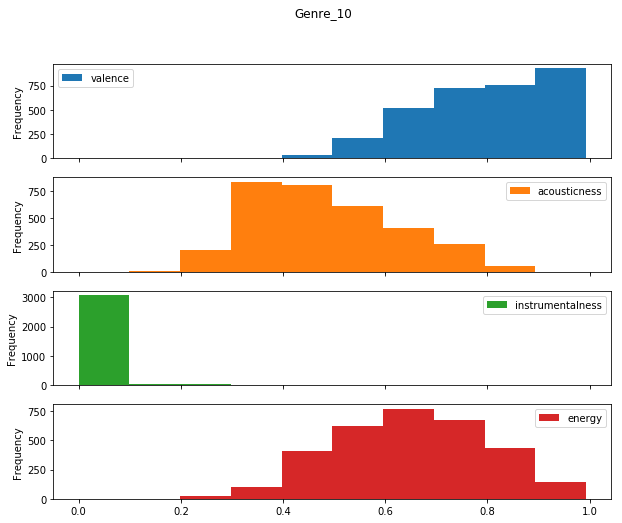

In [103]:
df[df['predicted'] == 10][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_10',figsize=(10,8));


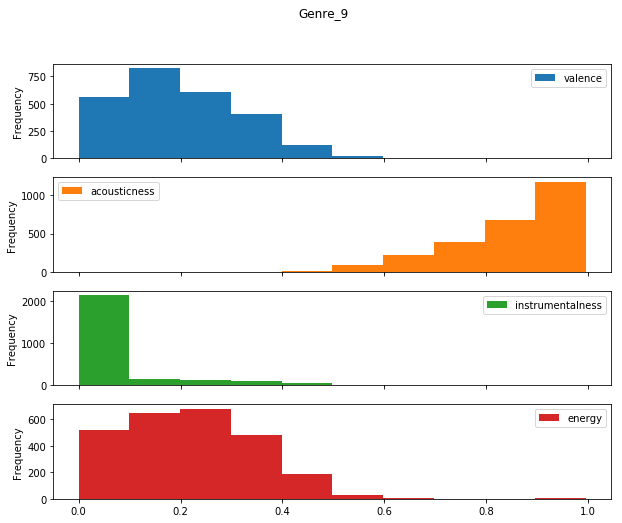

In [104]:
df[df['predicted'] == 9][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_9',figsize=(10,8));


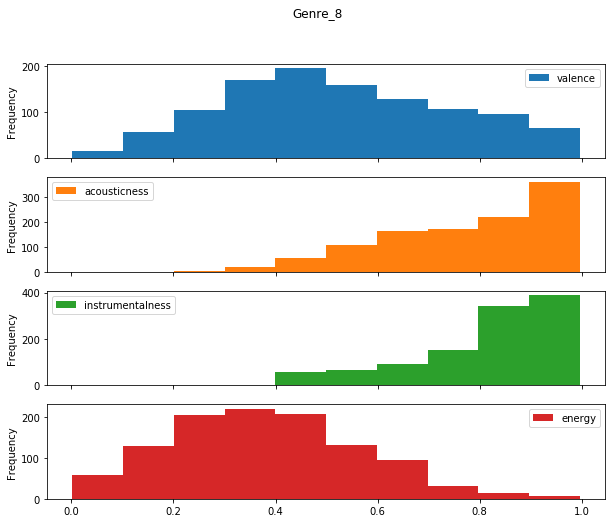

In [105]:
df[df['predicted'] == 8][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_8',figsize=(10,8));

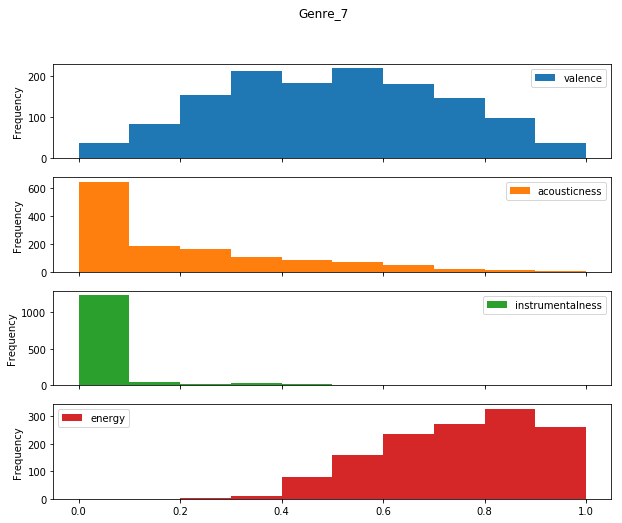

In [106]:
df[df['predicted'] == 7][['valence','acousticness', 'instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_7',figsize=(10,8));

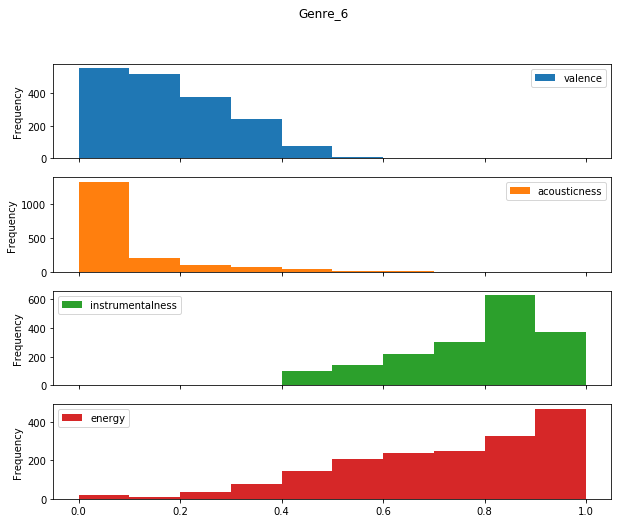

In [107]:
df[df['predicted'] == 6][['valence','acousticness', 'instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_6',figsize=(10,8));

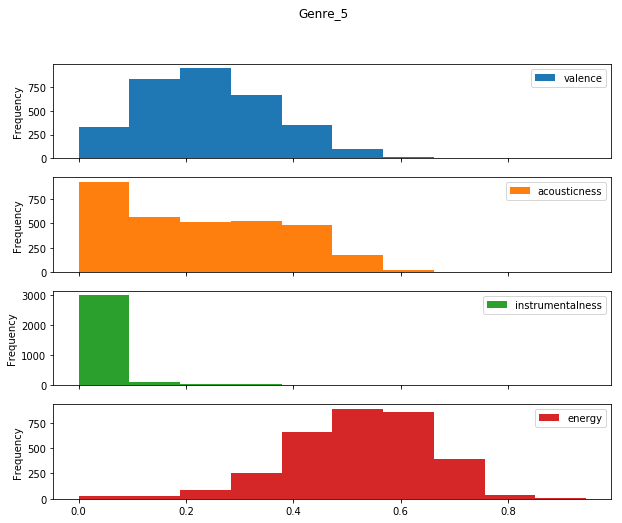

In [108]:
df[df['predicted'] == 5][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_5',figsize=(10,8));

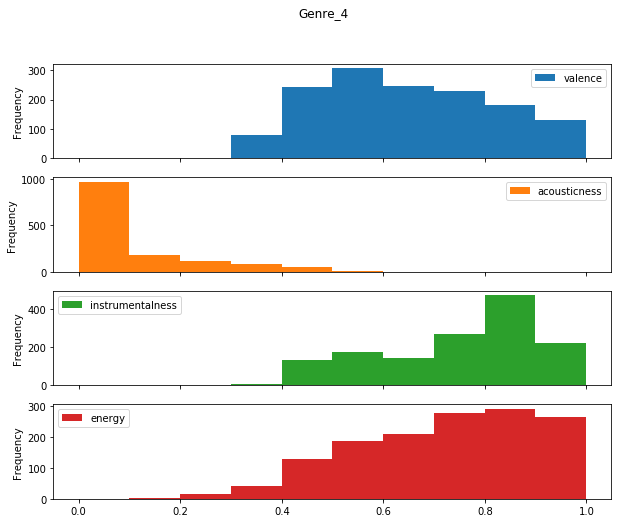

In [109]:
df[df['predicted'] == 4][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_4',figsize=(10,8));

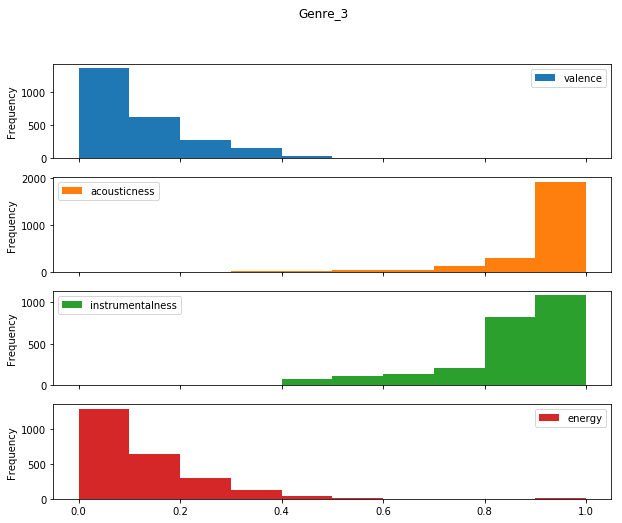

In [110]:
df[df['predicted'] == 3][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_3',figsize=(10,8));

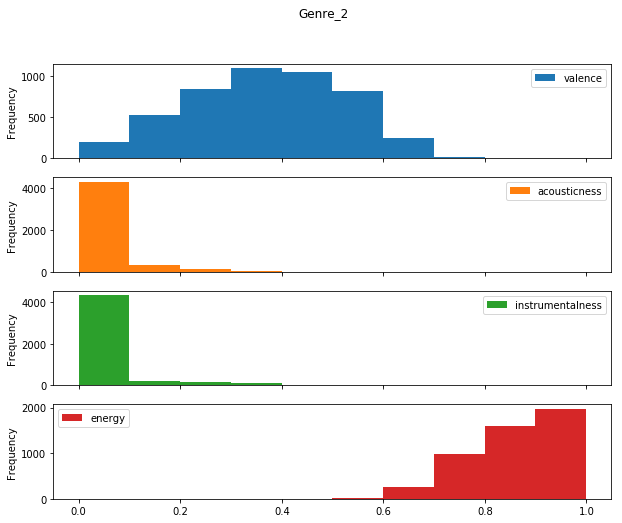

In [111]:
df[df['predicted'] == 2][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_2',figsize=(10,8));

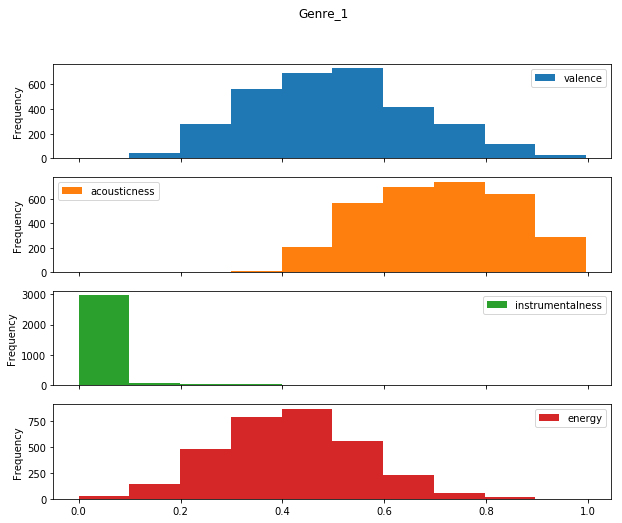

In [112]:
df[df['predicted'] == 1][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_1',figsize=(10,8));

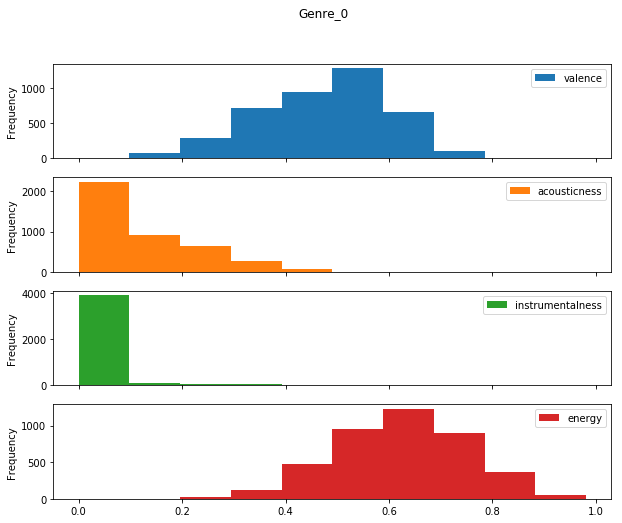

In [113]:
df[df['predicted'] == 0][['valence','acousticness','instrumentalness','energy']].plot(kind='hist', subplots=True, title='Genre_0',figsize=(10,8));

### Cross Referenced Value Counts
Of note besides pop the only other genres to lead in a cluster were dance and classical.

In [39]:
df[df['predicted'] == 11]['target'].value_counts(normalize=True)

pop                 0.426804
rock                0.139105
rap/hip hop         0.083531
dance               0.079295
mexicano/latino     0.074212
jazz/blues          0.055066
country, folk       0.047442
old school dance    0.046764
hardcore            0.029651
classical           0.008980
gospel/worship      0.006100
focus/sleep         0.003050
Name: target, dtype: float64

In [40]:
df[df['predicted'] == 10]['target'].value_counts(normalize=True)

pop                 0.385099
mexicano/latino     0.159069
rock                0.107828
jazz/blues          0.097139
rap/hip hop         0.077963
country, folk       0.063816
old school dance    0.039296
dance               0.035209
classical           0.013832
hardcore            0.011632
gospel/worship      0.006602
focus/sleep         0.002515
Name: target, dtype: float64

In [41]:
df[df['predicted'] == 9]['target'].value_counts(normalize=True)

pop                 0.370804
classical           0.243169
jazz/blues          0.124512
rock                0.063622
country, folk       0.059719
gospel/worship      0.028884
focus/sleep         0.026542
dance               0.021077
mexicano/latino     0.020297
old school dance    0.019516
rap/hip hop         0.012100
hardcore            0.009758
Name: target, dtype: float64

In [114]:
df[df['predicted'] == 8]['target'].value_counts(normalize=True)

classical           0.215847
jazz/blues          0.215847
pop                 0.171220
rap/hip hop         0.091075
dance               0.083789
focus/sleep         0.063752
rock                0.057377
country, folk       0.056466
mexicano/latino     0.020036
hardcore            0.011840
gospel/worship      0.006375
old school dance    0.006375
Name: target, dtype: float64

In [42]:
df[df['predicted'] == 7]['target'].value_counts(normalize=True)

pop                 0.312361
rock                0.157661
dance               0.109548
rap/hip hop         0.100666
hardcore            0.066617
gospel/worship      0.063657
jazz/blues          0.055514
mexicano/latino     0.046632
country, folk       0.034789
old school dance    0.028868
focus/sleep         0.014804
classical           0.008882
Name: target, dtype: float64

In [115]:
df[df['predicted'] == 6]['target'].value_counts(normalize=True)

dance               0.350818
pop                 0.153976
hardcore            0.129724
rock                0.108855
focus/sleep         0.080090
classical           0.078398
jazz/blues          0.049633
rap/hip hop         0.031585
country, folk       0.009024
old school dance    0.006768
mexicano/latino     0.001128
Name: target, dtype: float64

In [43]:
df[df['predicted'] == 5]['target'].value_counts(normalize=True)

pop                 0.442343
rock                0.149101
dance               0.091445
rap/hip hop         0.081525
country, folk       0.054247
gospel/worship      0.048667
jazz/blues          0.041228
old school dance    0.024489
hardcore            0.021389
mexicano/latino     0.017669
classical           0.013949
focus/sleep         0.013949
Name: target, dtype: float64

In [116]:
df[df['predicted'] == 4]['target'].value_counts(normalize=True)

dance               0.337094
pop                 0.237659
jazz/blues          0.126234
rock                0.089563
rap/hip hop         0.047955
old school dance    0.040903
classical           0.035966
hardcore            0.034556
mexicano/latino     0.021157
country, folk       0.016220
focus/sleep         0.011283
gospel/worship      0.001410
Name: target, dtype: float64

In [44]:
df[df['predicted'] == 3]['target'].value_counts(normalize=True)

classical           0.523322
focus/sleep         0.199673
pop                 0.085106
jazz/blues          0.078969
dance               0.031506
rock                0.027414
country, folk       0.022913
rap/hip hop         0.011457
hardcore            0.009820
gospel/worship      0.005319
mexicano/latino     0.002455
old school dance    0.002046
Name: target, dtype: float64

In [45]:
df[df['predicted'] == 2]['target'].value_counts(normalize=True)

pop                 0.349088
rock                0.233624
dance               0.151534
hardcore            0.129975
rap/hip hop         0.043532
country, folk       0.029436
jazz/blues          0.021144
gospel/worship      0.017620
old school dance    0.009950
classical           0.006633
mexicano/latino     0.004561
focus/sleep         0.002902
Name: target, dtype: float64

In [46]:
df[df['predicted'] == 1]['target'].value_counts(normalize=True)

pop                 0.438053
jazz/blues          0.137168
rock                0.103350
country, folk       0.080594
rap/hip hop         0.059418
mexicano/latino     0.050253
classical           0.038875
dance               0.031606
old school dance    0.030025
hardcore            0.013906
gospel/worship      0.011694
focus/sleep         0.005057
Name: target, dtype: float64

In [47]:
df[df['predicted'] == 0]['target'].value_counts(normalize=True)

pop                 0.384316
rap/hip hop         0.221140
dance               0.126400
rock                0.093522
jazz/blues          0.048466
old school dance    0.031174
country, folk       0.030200
hardcore            0.028495
mexicano/latino     0.018997
gospel/worship      0.006576
classical           0.006576
focus/sleep         0.004140
Name: target, dtype: float64

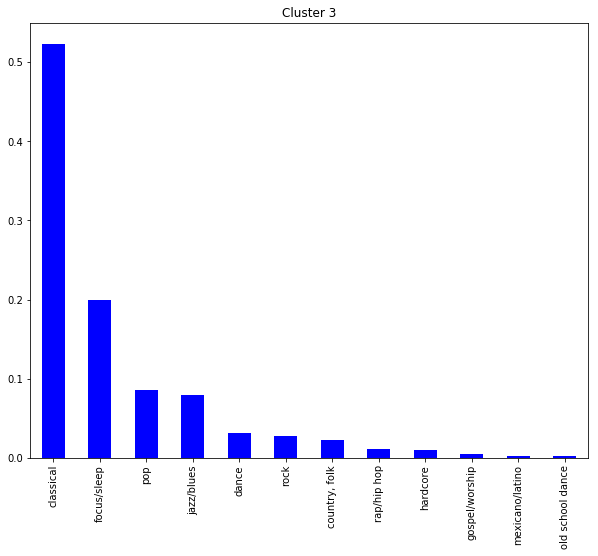

In [29]:
df[df['predicted'] == 3]['target'].value_counts(normalize=True).plot(kind='bar', figsize=(10,8), title='Cluster 3', color='blue');

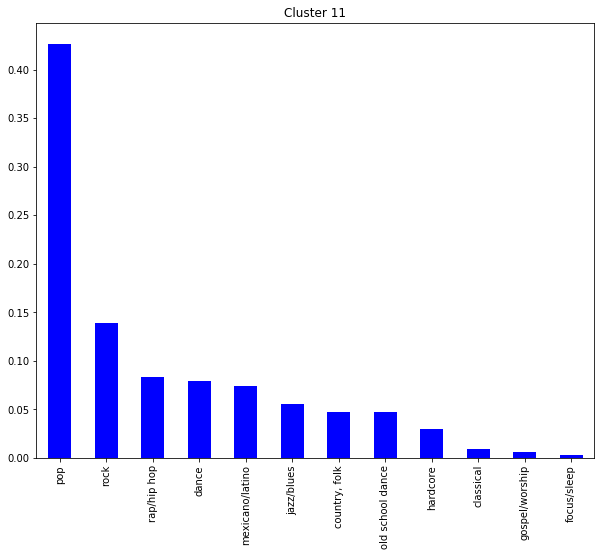

In [30]:
df[df['predicted'] == 11]['target'].value_counts(normalize=True).plot(kind='bar', figsize=(10,8), title='Cluster 11', color='blue');

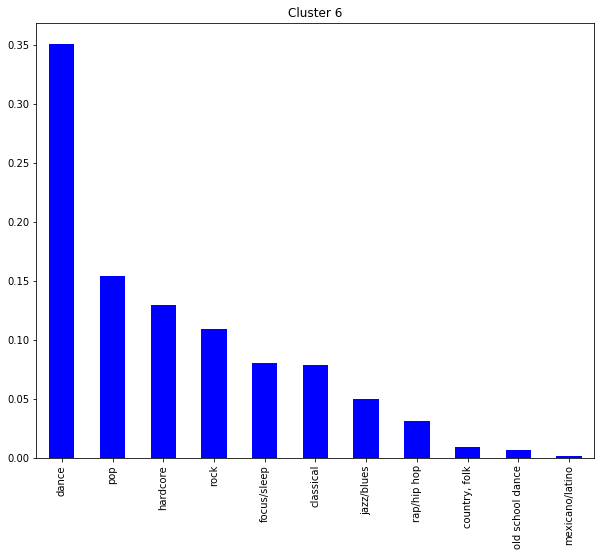

In [32]:
df[df['predicted'] == 6]['target'].value_counts(normalize=True).plot(kind='bar', figsize=(10,8), title='Cluster 6', color='blue');

# Conclusion

To make a genre predictor with the current features from the Spotify Api while also binning the data into 12 target genres produced inaccurate models. Many of the genres overlap on many features and made it quite difficult for a machine learning model to decifer between the various genres. The other problem was unbalanced classes, the pop music genre was about 35% of the total music out of 12 genres. The machine learning models favored the majority class, and penalized the minority classes, predicting up to 60% of the validation data was pop music. Looking for guidance in k-means cluster led to investigation of how a machine learning model could make 12 distinct clusters of music.In my last cluster, with only zero to one scaled fesatures, the only genres that were able to lead a cluster in population besides pop music were dance and classical. 

Looking into why dance and classical were favored over every other genre, we notice that clusters where classical music was the most populous we notice high in acousticness and instrumentalness and genrally lower in valence and energy. This is mostly due to large amount of instrumental music found in classical, the lack of a steady beat in classical and the lack of compression in classical music which leads to a high acousticness rating. The two clusters where dance music were most prevalent had high energy and instrumentalness and low in acousticness. They differed on one cluster had high valence and one had low valence. This is due to the amount of instrumental dance music, dance music is recorded quite loudly giving it high energy and due to the high amount of compression in the dance recording in has very low acousticness. To make a good genre predictor using machine learning models we need less genres for the models to predict or better features that are more precisly in tune with the differences in songs to the human ear. In the end music is subjective to the human experience and how we label music has cultural and historical connotation that a machine learning model can not truly grasp.